In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import subprocess
import os
import glob

from scipy.special import erf
import scipy.optimize as opt
from matplotlib.ticker import FixedLocator
from scipy.stats import norm
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


import matplotlib
import pickle


# Define the 2D Gaussian function
def gaussian_2d(X, A, x0, y0, sigma_x, sigma_y):
    x, y = X  # X is a tuple (x, y)
    return (A * np.exp(-(((x - x0) ** 2) / (2 * sigma_x ** 2) + ((y - y0) ** 2) / (2 * sigma_y ** 2)))).ravel()
# Define 1D Gaussian function
def gaussian_1d(y, A, y0, sigma_y):
    return A * np.exp(-((y - y0) ** 2) / (2 * sigma_y ** 2))

def check_bins_2D(ax):
    image =  ax.collections[0]  # The QuadMesh object
    x_edges = image._coordinates[0]  # Bin edges along X-axis
    y_edges = image._coordinates[1]  # Bin edges along Y-axis

    # Compute bin widths
    retrieved_bin_width_x = x_edges[1] - x_edges[0]
    retrieved_bin_width_y = y_edges[1] - y_edges[0]

    # Print results

    print(f"Retrieved bin width (X): {retrieved_bin_width_x}")
    print(f"Retrieved bin width (Y): {retrieved_bin_width_y}")

In [3]:
! ls /eos/home-c/cmaccani/DoubleChannelingFiles

Double_Channeling_450_TCCP_0.0.h5    Double_Channeling_450_TCCP_19.8.h5
Double_Channeling_450_TCCP_-11.0.h5  Double_Channeling_450_TCCP_-20.9.h5
Double_Channeling_450_TCCP_11.0.h5   Double_Channeling_450_TCCP_-22.0.h5
Double_Channeling_450_TCCP_-1.1.h5   Double_Channeling_450_TCCP_-2.2.h5
Double_Channeling_450_TCCP_1.1.h5    Double_Channeling_450_TCCP_2.2.h5
Double_Channeling_450_TCCP_-12.1.h5  Double_Channeling_450_TCCP_-3.3.h5
Double_Channeling_450_TCCP_12.1.h5   Double_Channeling_450_TCCP_3.3.h5
Double_Channeling_450_TCCP_-13.2.h5  Double_Channeling_450_TCCP_-4.4.h5
Double_Channeling_450_TCCP_13.2.h5   Double_Channeling_450_TCCP_4.4.h5
Double_Channeling_450_TCCP_-14.3.h5  Double_Channeling_450_TCCP_-5.5.h5
Double_Channeling_450_TCCP_14.3.h5   Double_Channeling_450_TCCP_5.5.h5
Double_Channeling_450_TCCP_-15.4.h5  Double_Channeling_450_TCCP_-6.6.h5
Double_Channeling_450_TCCP_15.4.h5   Double_Channeling_450_TCCP_6.6.h5
Double_Channeling_450_TCCP_-16.5.h5  Double_Channeling_450_TCCP_-7.

In [4]:
dc_files_path  = "/eos/home-c/cmaccani/DoubleChannelingFiles"

In [5]:
def plot_rectangle( ax, x_low, x_up, y_low, y_up, zorder = 100, linewidth = 1, edgecolor = 'r', facecolor='none', alpha=1):
    rect = matplotlib.patches.Rectangle((x_low, y_low), x_up - x_low, y_up - y_low, edgecolor=edgecolor, facecolor=facecolor, alpha = alpha, zorder=zorder, linewidth=linewidth)
    ax.add_patch(rect)
    
RPX_bottom_wall_thickess = 2.14e-3

def get_pentagonal(y_lim = 0.003):
    angles = [180-135, 90, 90, 90,135] 
    side_lengths = [31.1e-3, 10e-3, 32e-3, 32e-3, 10e-3]  
    angles = np.radians(angles)

    ALFA_x = [0]
    ALFA_y = [0]
    for i in range(len(side_lengths)):
        angle_sum = np.sum(angles[:i])
        ALFA_x.append(ALFA_x[-1] + side_lengths[i] * np.cos(angle_sum))
        ALFA_y.append(ALFA_y[-1] + side_lengths[i] * np.sin(angle_sum))
    # Close the pentagon by appending the first vertex at the end
    ALFA_x.append(ALFA_x[0])
    ALFA_y.append(ALFA_y[0])

    # Center in x an apply vertical offset
    ALFA_x = [i -side_lengths[0]/2 for i in ALFA_x]
    ALFA_y = [i + y_lim for i in ALFA_y]

    return np.array(ALFA_x), np.array(ALFA_y)

def get_intersections(jaw_L, ALFA_x, ALFA_y, y_horizontal = None, RPX_bottom_wall_thickess = 2.14e-3):

    y_horizontal = jaw_L + RPX_bottom_wall_thickess if y_horizontal is None else y_horizontal

    pentagon = []
    for i, j in zip(ALFA_x, ALFA_y):
        pentagon.append([i, j])

    intersections = []
   
    # Function to find the intersection between a horizontal line and a line segment
    def find_intersection(p1, p2, y_horizontal):
        x1, y1 = p1
        x2, y2 = p2
        
        # Check if the line segment intersects the horizontal line
        if (y1 - y_horizontal) * (y2 - y_horizontal) <= 0:
            # Calculate the intersection point
            if y1 != y2:
                x_intersect = x1 + (x2 - x1) * (y_horizontal - y1) / (y2 - y1)
                return (x_intersect, y_horizontal)
        return None

    for i in range(len(pentagon)):
        p1 = pentagon[i]
        p2 = pentagon[(i + 1) % len(pentagon)]
        intersection = find_intersection(p1, p2, y_horizontal)
        if intersection:
            intersections.append(intersection)

    return intersections

def plot_simulations_TFT(fig, ax_or_spec, x, y, jaw_L, abs_y_low, vmin=None, vmax=None, print_vmax=False, n_sigma=5.5,
                         sigma_line=False, n_ticks=2, log_norm=True, plot_fit=False, fit = False,
                         plot_max_dot=False, plot_cbar=True, print_count=True, return_fit=False, add_box=False):
    
    if isinstance(ax_or_spec, matplotlib.gridspec.SubplotSpec):
        inner_gs = matplotlib.gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=ax_or_spec, width_ratios=[0.80, 0.03], wspace=0.17) 
    else:
        ax_or_spec = matplotlib.gridspec.GridSpec(1, 1, figure=fig)
        inner_gs = matplotlib.gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=ax_or_spec[0], width_ratios=[0.80, 0.03], wspace=0.17)

    ax = fig.add_subplot(inner_gs[0])
    ax_cb = fig.add_subplot(inner_gs[1])
    ALFA_x, ALFA_y = get_pentagonal(y_lim=jaw_L + 500e-6)
    ax.plot(ALFA_x, ALFA_y, color='r', lw=2)
    xlim = [min(np.min(ALFA_x) - 1e-3, min(x)), max(np.max(ALFA_x) + 1e-3, max(x))]
    ylim = [min(jaw_L, min(y)), max(np.max(ALFA_y) + 1e-3, max(y))]

    ax.set_xlabel("x [mm]", fontsize=14)
    ax.set_ylabel("y [mm]", fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.grid(linestyle=":")

    alfa_resolution = 30e-6
    bins_x = round((xlim[1] - xlim[0]) / alfa_resolution)
    bins_y = round((ylim[1] - ylim[0]) / alfa_resolution)

    cmap = plt.cm.viridis.copy()
    cmap.set_under('white')
    norm = matplotlib.colors.LogNorm(vmin=vmin, vmax=vmax) if log_norm else matplotlib.colors.Normalize(vmin=1e-5)
    h = ax.hist2d(x, y, norm=norm, bins=[bins_x, bins_y], range=[xlim, ylim], cmap=cmap)

    if print_vmax:
        norm.autoscale(h[0])
        print('vmax: ', norm.vmax)

    x_centers = (h[1][:-1] + h[1][1:]) / 2
    y_centers = (h[2][:-1] + h[2][1:]) / 2

    filtered_hist = h[0].copy()
    for j, y_center in enumerate(y_centers):
        if y_center < abs_y_low:
            filtered_hist[:, j] = -np.inf

    max_count = np.max(filtered_hist)
    max_index = np.unravel_index(np.argmax(filtered_hist), h[0].shape)
    max_bin_x = (h[1][max_index[0]] + h[1][max_index[0] + 1]) / 2
    max_bin_y = (h[2][max_index[1]] + h[2][max_index[1] + 1]) / 2

    n_impacts = len(y[y > abs_y_low])
    if plot_max_dot:
        ax.plot(max_bin_x, max_bin_y, 'ro', markersize=2)
        print(f"The bin with the highest value is at ({max_bin_x:.6f}, {max_bin_y:.6f}) with a count of {max_count}.")
        print(f'Total impacts: {n_impacts}, max count normalized by total impacts: {max_count/n_impacts:.5f}')

    ax.set_xticks(ticks=ax.get_xticks(), labels=[f"{x_tick*1e3:.1f}" for x_tick in ax.get_xticks()])
    ax.set_yticks(ticks=ax.get_yticks(), labels=[f"{y_tick*1e3:.1f}" for y_tick in ax.get_yticks()])

    ALFA_x, ALFA_y = get_pentagonal(y_lim=jaw_L + 200e-6)
    intersections = get_intersections(jaw_L, ALFA_x, ALFA_y)
    ax.plot(ALFA_x, ALFA_y, 'grey', linewidth=2)
    ax.axhline(jaw_L, color='grey', linestyle='-', zorder=10)
    ax.plot([xlim[0], intersections[1][0]], [jaw_L + RPX_bottom_wall_thickess] * 2, color='grey', linestyle='-', zorder=10)
    ax.plot([intersections[0][0], xlim[1]], [jaw_L + RPX_bottom_wall_thickess] * 2, color='grey', linestyle='-', zorder=10)

    if plot_cbar:
        cbar = fig.colorbar(h[3], cax=ax_cb, orientation='vertical')
        if print_count:
            cbar.set_label('Counts', fontsize=14)
        cbar.ax.tick_params(labelsize=12)

    ax.grid(linestyle=':')
    if fit:
        X, Y = np.meshgrid(x_centers, y_centers, indexing='ij')
        xdata = np.vstack((X.ravel(), Y.ravel()))
        zdata = h[0].ravel()

        def gaussian_2d(coords, amp, x0, y0, sigma_x, sigma_y, offset):
            x, y = coords
            return amp * np.exp(-(((x - x0) ** 2) / (2 * sigma_x ** 2) + ((y - y0) ** 2) / (2 * sigma_y ** 2))) + offset

        initial_guess = (np.max(zdata), np.mean(x), np.mean(y), np.std(x), np.std(y), 0)
        popt, pcov = curve_fit(gaussian_2d, xdata, zdata, p0=initial_guess)
        fit_data = gaussian_2d((X, Y), *popt)
        perr = np.sqrt(np.diag(pcov))

        fit_df = pd.DataFrame({"Parameter": ["amplitude", "x0", "y0", "sigma_x", "sigma_y", "offset"],
                            "Value": popt,
                            "StdError": perr})
        print(fit_df)

        if plot_fit:
            ax.plot(popt[1], popt[2], 'ro', markersize=2, label='Gaussian Fit Center')
            ellipse = matplotlib.patches.Ellipse((popt[1], popt[2]), width=6*popt[3], height=6*popt[4],
                                                edgecolor='g', facecolor='none', linewidth=2, zorder=4)
            ax.add_patch(ellipse)



        if add_box:
            legend_text = f"Fit center: ({popt[1]*1e3:.2f}, {popt[2]*1e3:.2f}) mm\nFit sigma: ({popt[3]*1e3:.2f}, {popt[4]*1e3:.2f}) mm"
            ax.text(0.95, 0.95, legend_text, ha="right", va="top", transform=ax.transAxes, fontsize=12, bbox=dict(facecolor='white', edgecolor='black', boxstyle="round,pad=0.5"))
            

        if return_fit:
            return fit_df
        
    ax_tw = ax.twinx()
    ref = 0
    sigma_abs = jaw_L / n_sigma
    ax_tw.set_ylim((ax.get_ylim()[0]-ref)/sigma_abs, (ax.get_ylim()[1]-ref)/sigma_abs)
    yticks = np.arange(np.ceil(ax_tw.get_ylim()[0]), np.floor(ax_tw.get_ylim()[1]) + 1, n_ticks)
    ax_tw.set_yticks(yticks)
    ax_tw.set_ylabel(r' n $\sigma$', fontsize=14)
    ax_tw.tick_params(axis='both', which='major', labelsize=12)
    if sigma_line:
        ax_tw.axhline(n_sigma, color='r', linestyle='--')
    ax.set_ylim(ylim[0], ylim[1])
    ax.set_xlim(xlim[0], xlim[1])


In [6]:
df_TFT = pd.read_hdf(f"{dc_files_path}/Double_Channeling_450_TCCP_0.0.h5", key = "TFT_data" )
df_PIX = pd.read_hdf(f"{dc_files_path}/Double_Channeling_450_TCCP_0.0.h5", key = "PIXEL_data" )
metadata = pd.read_hdf(f"{dc_files_path}/Double_Channeling_450_TCCP_0.0.h5", key = "metadata" )

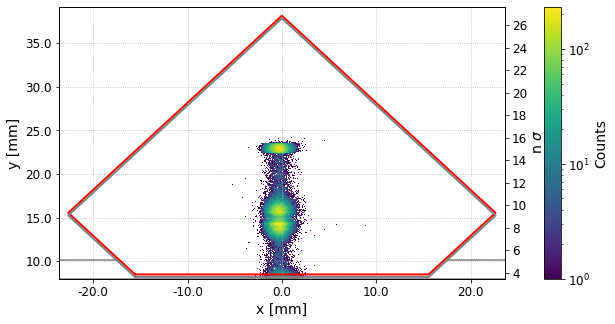

In [7]:
fig = plt.figure(figsize=(9, 5))
#x = fig.add_subplot(111)
x = df_TFT["x"]
y = df_TFT["y"]
jaw_L = 5.5 *0.0014479740312245593 #+ RPX_bottom_wall_thickess 
abs_y_low = jaw_L #+ 500e-6
plot_simulations_TFT(fig, None, x, y, jaw_L, abs_y_low, return_fit=True, add_box=True,)

In [8]:
def get_TFT_array(df_TFT, show_plot = True):
    x = df_TFT["x"]
    y = df_TFT["y"]
    jaw_L = 5.5 *0.0014479740312245593 #+ RPX_bottom_wall_thickess 
    abs_y_low = jaw_L #+ 500e-6

    fig, ax = plt.subplots(figsize=(23/2, 35/4))
    vmax, vmin = None, None
    ALFA_x, ALFA_y = get_pentagonal(y_lim= jaw_L + 0.003)
    ax.plot(ALFA_x, ALFA_y, color='r', lw=2)
    xlim = [-0.023, 0.023] #[min(np.min(ALFA_x) - 1e-3, min(x)), max(np.max(ALFA_x) + 1e-3, max(x))]
    ylim = [jaw_L, jaw_L+0.035]#[min(jaw_L, min(y)), max(np.max(ALFA_y) + 1e-3, max(y))]

    ax.set_xlabel("x [mm]", fontsize=14)
    ax.set_ylabel("y [mm]", fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.grid(linestyle=":")

    alfa_resolution = 30e-6
    bins_x = 1500 #round((xlim[1] - xlim[0]) / alfa_resolution)
    bins_y = 1500 #round((ylim[1] - ylim[0]) / alfa_resolution)

    cmap = plt.cm.viridis.copy()
    cmap.set_under('white')
    norm = matplotlib.colors.LogNorm(vmin=vmin, vmax=vmax) 
    h_TFT = ax.hist2d(x, y, norm=norm, bins=[bins_x, bins_y], range=[xlim, ylim], cmap=cmap)
    check_bins_2D(ax)
    if show_plot:
        plt.show()
    else:
        plt.close(fig)
    return h_TFT
   

In [9]:
def get_PIX_array(df_PIX, show_plot=True):
    x_df = df_PIX["x"]
    y_df = df_PIX["y"]
    PIX_y_distance_to_RPX = 0.00314
    ydim=0.01408
    xdim=0.04224
    f = 500
    fig, ax = plt.subplots(figsize=(xdim*f, ydim*f))
    jaw_L = 5.5*0.0014479740312245593
    abs_y_low = jaw_L
    abs_y_up = jaw_L + ydim
    abs_x_low = -xdim/2
    abs_x_up = xdim/2
    abs_y_up = abs_y_up #+ PIX_y_distance_to_RPX
    abs_y_low = abs_y_low #+ PIX_y_distance_to_RPX
    vmax, vmin = None, None
    plot_rectangle(ax, abs_x_low, abs_x_low + xdim/3, abs_y_low, abs_y_up)
    plot_rectangle(ax, abs_x_low + xdim/3, abs_x_low + xdim/3*2, abs_y_low, abs_y_up)
    plot_rectangle(ax, abs_x_low + xdim/3*2, abs_x_up, abs_y_low, abs_y_up)
    xlim = [-xdim/2, xdim/2] #[min(np.min(ALFA_x) - 1e-3, min(x)), max(np.max(ALFA_x) + 1e-3, max(x))]
    ylim = [jaw_L, jaw_L + ydim]#[min(jaw_L, min(y)), max(np.max(ALFA_y) + 1e-3, max(y))]
    x = x_df[(x_df > abs_x_low) & (x_df < abs_x_up) & (y_df > abs_y_low) & (y_df < abs_y_up)]
    y = y_df[(x_df > abs_x_low) & (x_df < abs_x_up) &(y_df > abs_y_low) & (y_df < abs_y_up)]

    ax.set_xlabel("x [mm]", fontsize=14)
    ax.set_ylabel("y [mm]", fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.grid(linestyle=":")

    bins_x = 768 #round((xlim[1] - xlim[0]) / alfa_resolution)
    bins_y = 256 #round((ylim[1] - ylim[0]) / alfa_resolution)

    cmap = plt.cm.viridis.copy()
    cmap.set_under('white')
    norm = matplotlib.colors.LogNorm(vmin=vmin, vmax=vmax) 
    h_PIX = ax.hist2d(x, y, norm=norm, bins=[bins_x, bins_y], range=[xlim, ylim], cmap=cmap)

    ax.set_xlim(xlim[0]-1e-3, xlim[1]+1e-3)
    ax.set_ylim(ylim[0]-1e-3, ylim[1]+1e-3)
    check_bins_2D(ax)
    if show_plot:
        plt.show()
    else:
        plt.close(fig)
    return h_PIX

In [10]:
dc_files_path  = "/eos/home-c/cmaccani/DoubleChannelingFiles"

file_names_output = subprocess.check_output("ls " + dc_files_path, shell=True).decode('ascii').strip()


file_names_list = file_names_output.split()

path_list = []

for file_name in file_names_list:
    file_path = os.path.join(dc_files_path, file_name)
    if os.path.exists(file_path):  
        path_list.append(file_path)

print(path_list) 
print("Number of files: ", len(path_list))

['/eos/home-c/cmaccani/DoubleChannelingFiles/Double_Channeling_450_TCCP_0.0.h5', '/eos/home-c/cmaccani/DoubleChannelingFiles/Double_Channeling_450_TCCP_-11.0.h5', '/eos/home-c/cmaccani/DoubleChannelingFiles/Double_Channeling_450_TCCP_11.0.h5', '/eos/home-c/cmaccani/DoubleChannelingFiles/Double_Channeling_450_TCCP_-1.1.h5', '/eos/home-c/cmaccani/DoubleChannelingFiles/Double_Channeling_450_TCCP_1.1.h5', '/eos/home-c/cmaccani/DoubleChannelingFiles/Double_Channeling_450_TCCP_-12.1.h5', '/eos/home-c/cmaccani/DoubleChannelingFiles/Double_Channeling_450_TCCP_12.1.h5', '/eos/home-c/cmaccani/DoubleChannelingFiles/Double_Channeling_450_TCCP_-13.2.h5', '/eos/home-c/cmaccani/DoubleChannelingFiles/Double_Channeling_450_TCCP_13.2.h5', '/eos/home-c/cmaccani/DoubleChannelingFiles/Double_Channeling_450_TCCP_-14.3.h5', '/eos/home-c/cmaccani/DoubleChannelingFiles/Double_Channeling_450_TCCP_14.3.h5', '/eos/home-c/cmaccani/DoubleChannelingFiles/Double_Channeling_450_TCCP_-15.4.h5', '/eos/home-c/cmaccani/Do

In [ ]:
keys = [0.0, -11.0, 11.0, -1.1, 1.1, -12.1, 12.1, -13.2, 13.2, -14.3, 14.3, -15.4, 15.4, -16.5,16.5, -17.6, 17.6, -18.7,
 18.7, -19.8, 19.8, -20.9, -22.0, -2.2, 2.2, -3.3, 3.3, -4.4, 4.4, -5.5, 5.5, -6.6, 6.6, -7.7, 7.7, -8.8, 8.8, -9.9, 9.9]

In [11]:
output_hdf_path = "./DoubleChanneling_450GeV_ANGSCAN.h5"

In [45]:
with pd.HDFStore(output_hdf_path, mode='w', complevel=9, complib='blosc') as store:
    for file_path in path_list:
        key = float(file_path.split("TCCP_")[1].split(".h5")[0])
        store_key = f"{str(key)}"
        print(f"Processing key: {key} → {store_key}")

        # Read data
        df_TFT = pd.read_hdf(file_path, key="TFT_data")
        df_PIX = pd.read_hdf(file_path, key="PIXEL_data")
        metadata = pd.read_hdf(file_path, key="metadata")
        TCCP_align_angle = metadata["TCCP_align_angle"].iloc[0]
        TCCP_absorbed = metadata["TCCP_absorbed"].iloc[0]

        # Compute arrays
        h_PIX = get_PIX_array(df_PIX, show_plot=False)[0]
        h_TFT = get_TFT_array(df_TFT, show_plot=False)[0]

        # Store arrays directly as DataFrames
        store.put(f"{store_key}/h_PIX", pd.DataFrame(h_PIX), format='table')
        store.put(f"{store_key}/h_TFT", pd.DataFrame(h_TFT), format='table')

        # Store scalar values as a one-row DataFrame
        scalars_df = pd.DataFrame({
            "TCCP_align_angle": [TCCP_align_angle],
            "TCCP_absorbed": [TCCP_absorbed]
        })
        store.put(f"{store_key}/metadata", scalars_df, format='table')

Processing key: 0.0 → 0.0
Retrieved bin width (X): [5.5e-05 0.0e+00]
Retrieved bin width (Y): [5.5e-05 0.0e+00]
Retrieved bin width (X): [3.06666667e-05 0.00000000e+00]
Retrieved bin width (Y): [3.06666667e-05 0.00000000e+00]
Processing key: -11.0 → -11.0


/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '0.0'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


Retrieved bin width (X): [5.5e-05 0.0e+00]
Retrieved bin width (Y): [5.5e-05 0.0e+00]
Retrieved bin width (X): [3.06666667e-05 0.00000000e+00]
Retrieved bin width (Y): [3.06666667e-05 0.00000000e+00]
Processing key: 11.0 → 11.0


/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '-11.0'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


Retrieved bin width (X): [5.5e-05 0.0e+00]
Retrieved bin width (Y): [5.5e-05 0.0e+00]
Retrieved bin width (X): [3.06666667e-05 0.00000000e+00]
Retrieved bin width (Y): [3.06666667e-05 0.00000000e+00]
Processing key: -1.1 → -1.1


/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '11.0'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


Retrieved bin width (X): [5.5e-05 0.0e+00]
Retrieved bin width (Y): [5.5e-05 0.0e+00]
Retrieved bin width (X): [3.06666667e-05 0.00000000e+00]
Retrieved bin width (Y): [3.06666667e-05 0.00000000e+00]
Processing key: 1.1 → 1.1


/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '-1.1'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


Retrieved bin width (X): [5.5e-05 0.0e+00]
Retrieved bin width (Y): [5.5e-05 0.0e+00]
Retrieved bin width (X): [3.06666667e-05 0.00000000e+00]
Retrieved bin width (Y): [3.06666667e-05 0.00000000e+00]
Processing key: -12.1 → -12.1


/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '1.1'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


Retrieved bin width (X): [5.5e-05 0.0e+00]
Retrieved bin width (Y): [5.5e-05 0.0e+00]
Retrieved bin width (X): [3.06666667e-05 0.00000000e+00]
Retrieved bin width (Y): [3.06666667e-05 0.00000000e+00]
Processing key: 12.1 → 12.1


/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '-12.1'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


Retrieved bin width (X): [5.5e-05 0.0e+00]
Retrieved bin width (Y): [5.5e-05 0.0e+00]
Retrieved bin width (X): [3.06666667e-05 0.00000000e+00]
Retrieved bin width (Y): [3.06666667e-05 0.00000000e+00]
Processing key: -13.2 → -13.2


/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '12.1'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


Retrieved bin width (X): [5.5e-05 0.0e+00]
Retrieved bin width (Y): [5.5e-05 0.0e+00]
Retrieved bin width (X): [3.06666667e-05 0.00000000e+00]
Retrieved bin width (Y): [3.06666667e-05 0.00000000e+00]
Processing key: 13.2 → 13.2


/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '-13.2'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


Retrieved bin width (X): [5.5e-05 0.0e+00]
Retrieved bin width (Y): [5.5e-05 0.0e+00]
Retrieved bin width (X): [3.06666667e-05 0.00000000e+00]
Retrieved bin width (Y): [3.06666667e-05 0.00000000e+00]
Processing key: -14.3 → -14.3


/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '13.2'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


Retrieved bin width (X): [5.5e-05 0.0e+00]
Retrieved bin width (Y): [5.5e-05 0.0e+00]
Retrieved bin width (X): [3.06666667e-05 0.00000000e+00]
Retrieved bin width (Y): [3.06666667e-05 0.00000000e+00]
Processing key: 14.3 → 14.3


/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '-14.3'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


Retrieved bin width (X): [5.5e-05 0.0e+00]
Retrieved bin width (Y): [5.5e-05 0.0e+00]
Retrieved bin width (X): [3.06666667e-05 0.00000000e+00]
Retrieved bin width (Y): [3.06666667e-05 0.00000000e+00]
Processing key: -15.4 → -15.4


/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '14.3'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


Retrieved bin width (X): [5.5e-05 0.0e+00]
Retrieved bin width (Y): [5.5e-05 0.0e+00]
Retrieved bin width (X): [3.06666667e-05 0.00000000e+00]
Retrieved bin width (Y): [3.06666667e-05 0.00000000e+00]
Processing key: 15.4 → 15.4


/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '-15.4'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


Retrieved bin width (X): [5.5e-05 0.0e+00]
Retrieved bin width (Y): [5.5e-05 0.0e+00]
Retrieved bin width (X): [3.06666667e-05 0.00000000e+00]
Retrieved bin width (Y): [3.06666667e-05 0.00000000e+00]
Processing key: -16.5 → -16.5


/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '15.4'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


Retrieved bin width (X): [5.5e-05 0.0e+00]
Retrieved bin width (Y): [5.5e-05 0.0e+00]
Retrieved bin width (X): [3.06666667e-05 0.00000000e+00]
Retrieved bin width (Y): [3.06666667e-05 0.00000000e+00]
Processing key: 16.5 → 16.5


/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '-16.5'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


Retrieved bin width (X): [5.5e-05 0.0e+00]
Retrieved bin width (Y): [5.5e-05 0.0e+00]
Retrieved bin width (X): [3.06666667e-05 0.00000000e+00]
Retrieved bin width (Y): [3.06666667e-05 0.00000000e+00]
Processing key: -17.6 → -17.6


/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '16.5'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


Retrieved bin width (X): [5.5e-05 0.0e+00]
Retrieved bin width (Y): [5.5e-05 0.0e+00]
Retrieved bin width (X): [3.06666667e-05 0.00000000e+00]
Retrieved bin width (Y): [3.06666667e-05 0.00000000e+00]
Processing key: 17.6 → 17.6


/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '-17.6'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


Retrieved bin width (X): [5.5e-05 0.0e+00]
Retrieved bin width (Y): [5.5e-05 0.0e+00]
Retrieved bin width (X): [3.06666667e-05 0.00000000e+00]
Retrieved bin width (Y): [3.06666667e-05 0.00000000e+00]
Processing key: -18.7 → -18.7


/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '17.6'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


Retrieved bin width (X): [5.5e-05 0.0e+00]
Retrieved bin width (Y): [5.5e-05 0.0e+00]
Retrieved bin width (X): [3.06666667e-05 0.00000000e+00]
Retrieved bin width (Y): [3.06666667e-05 0.00000000e+00]
Processing key: 18.7 → 18.7


/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '-18.7'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


Retrieved bin width (X): [5.5e-05 0.0e+00]
Retrieved bin width (Y): [5.5e-05 0.0e+00]
Retrieved bin width (X): [3.06666667e-05 0.00000000e+00]
Retrieved bin width (Y): [3.06666667e-05 0.00000000e+00]
Processing key: -19.8 → -19.8


/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '18.7'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


Retrieved bin width (X): [5.5e-05 0.0e+00]
Retrieved bin width (Y): [5.5e-05 0.0e+00]
Retrieved bin width (X): [3.06666667e-05 0.00000000e+00]
Retrieved bin width (Y): [3.06666667e-05 0.00000000e+00]
Processing key: 19.8 → 19.8


/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '-19.8'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


Retrieved bin width (X): [5.5e-05 0.0e+00]
Retrieved bin width (Y): [5.5e-05 0.0e+00]
Retrieved bin width (X): [3.06666667e-05 0.00000000e+00]
Retrieved bin width (Y): [3.06666667e-05 0.00000000e+00]
Processing key: -20.9 → -20.9


/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '19.8'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


Retrieved bin width (X): [5.5e-05 0.0e+00]
Retrieved bin width (Y): [5.5e-05 0.0e+00]
Retrieved bin width (X): [3.06666667e-05 0.00000000e+00]
Retrieved bin width (Y): [3.06666667e-05 0.00000000e+00]
Processing key: -22.0 → -22.0


/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '-20.9'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


Retrieved bin width (X): [5.5e-05 0.0e+00]
Retrieved bin width (Y): [5.5e-05 0.0e+00]
Retrieved bin width (X): [3.06666667e-05 0.00000000e+00]
Retrieved bin width (Y): [3.06666667e-05 0.00000000e+00]
Processing key: -2.2 → -2.2


/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '-22.0'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


Retrieved bin width (X): [5.5e-05 0.0e+00]
Retrieved bin width (Y): [5.5e-05 0.0e+00]
Retrieved bin width (X): [3.06666667e-05 0.00000000e+00]
Retrieved bin width (Y): [3.06666667e-05 0.00000000e+00]
Processing key: 2.2 → 2.2


/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '-2.2'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


Retrieved bin width (X): [5.5e-05 0.0e+00]
Retrieved bin width (Y): [5.5e-05 0.0e+00]
Retrieved bin width (X): [3.06666667e-05 0.00000000e+00]
Retrieved bin width (Y): [3.06666667e-05 0.00000000e+00]
Processing key: -3.3 → -3.3


/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '2.2'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


Retrieved bin width (X): [5.5e-05 0.0e+00]
Retrieved bin width (Y): [5.5e-05 0.0e+00]
Retrieved bin width (X): [3.06666667e-05 0.00000000e+00]
Retrieved bin width (Y): [3.06666667e-05 0.00000000e+00]
Processing key: 3.3 → 3.3


/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '-3.3'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


Retrieved bin width (X): [5.5e-05 0.0e+00]
Retrieved bin width (Y): [5.5e-05 0.0e+00]
Retrieved bin width (X): [3.06666667e-05 0.00000000e+00]
Retrieved bin width (Y): [3.06666667e-05 0.00000000e+00]
Processing key: -4.4 → -4.4


/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '3.3'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


Retrieved bin width (X): [5.5e-05 0.0e+00]
Retrieved bin width (Y): [5.5e-05 0.0e+00]
Retrieved bin width (X): [3.06666667e-05 0.00000000e+00]
Retrieved bin width (Y): [3.06666667e-05 0.00000000e+00]
Processing key: 4.4 → 4.4


/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '-4.4'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


Retrieved bin width (X): [5.5e-05 0.0e+00]
Retrieved bin width (Y): [5.5e-05 0.0e+00]
Retrieved bin width (X): [3.06666667e-05 0.00000000e+00]
Retrieved bin width (Y): [3.06666667e-05 0.00000000e+00]
Processing key: -5.5 → -5.5


/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '4.4'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


Retrieved bin width (X): [5.5e-05 0.0e+00]
Retrieved bin width (Y): [5.5e-05 0.0e+00]
Retrieved bin width (X): [3.06666667e-05 0.00000000e+00]
Retrieved bin width (Y): [3.06666667e-05 0.00000000e+00]
Processing key: 5.5 → 5.5


/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '-5.5'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


Retrieved bin width (X): [5.5e-05 0.0e+00]
Retrieved bin width (Y): [5.5e-05 0.0e+00]
Retrieved bin width (X): [3.06666667e-05 0.00000000e+00]
Retrieved bin width (Y): [3.06666667e-05 0.00000000e+00]
Processing key: -6.6 → -6.6


/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '5.5'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


Retrieved bin width (X): [5.5e-05 0.0e+00]
Retrieved bin width (Y): [5.5e-05 0.0e+00]
Retrieved bin width (X): [3.06666667e-05 0.00000000e+00]
Retrieved bin width (Y): [3.06666667e-05 0.00000000e+00]
Processing key: 6.6 → 6.6


/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '-6.6'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


Retrieved bin width (X): [5.5e-05 0.0e+00]
Retrieved bin width (Y): [5.5e-05 0.0e+00]
Retrieved bin width (X): [3.06666667e-05 0.00000000e+00]
Retrieved bin width (Y): [3.06666667e-05 0.00000000e+00]
Processing key: -7.7 → -7.7


/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '6.6'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


Retrieved bin width (X): [5.5e-05 0.0e+00]
Retrieved bin width (Y): [5.5e-05 0.0e+00]
Retrieved bin width (X): [3.06666667e-05 0.00000000e+00]
Retrieved bin width (Y): [3.06666667e-05 0.00000000e+00]
Processing key: 7.7 → 7.7


/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '-7.7'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


Retrieved bin width (X): [5.5e-05 0.0e+00]
Retrieved bin width (Y): [5.5e-05 0.0e+00]
Retrieved bin width (X): [3.06666667e-05 0.00000000e+00]
Retrieved bin width (Y): [3.06666667e-05 0.00000000e+00]
Processing key: -8.8 → -8.8


/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '7.7'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


Retrieved bin width (X): [5.5e-05 0.0e+00]
Retrieved bin width (Y): [5.5e-05 0.0e+00]
Retrieved bin width (X): [3.06666667e-05 0.00000000e+00]
Retrieved bin width (Y): [3.06666667e-05 0.00000000e+00]
Processing key: 8.8 → 8.8


/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '-8.8'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


Retrieved bin width (X): [5.5e-05 0.0e+00]
Retrieved bin width (Y): [5.5e-05 0.0e+00]
Retrieved bin width (X): [3.06666667e-05 0.00000000e+00]
Retrieved bin width (Y): [3.06666667e-05 0.00000000e+00]
Processing key: -9.9 → -9.9


/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '8.8'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


Retrieved bin width (X): [5.5e-05 0.0e+00]
Retrieved bin width (Y): [5.5e-05 0.0e+00]
Retrieved bin width (X): [3.06666667e-05 0.00000000e+00]
Retrieved bin width (Y): [3.06666667e-05 0.00000000e+00]
Processing key: 9.9 → 9.9


/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '-9.9'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


Retrieved bin width (X): [5.5e-05 0.0e+00]
Retrieved bin width (Y): [5.5e-05 0.0e+00]
Retrieved bin width (X): [3.06666667e-05 0.00000000e+00]
Retrieved bin width (Y): [3.06666667e-05 0.00000000e+00]


/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '9.9'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


In [11]:
output_hdf_path = "./DoubleChanneling_450GeV_ANGSCAN.h5"

In [79]:
with pd.HDFStore(output_hdf_path, mode='r') as store:
    key = 11.0
  
    h_PIX = store[f"{key}/h_PIX"].values
    h_TFT = store[f"{key}/h_TFT"].values

    metadata = store[f"{key}/metadata"]
    TCCP_align_angle = metadata["TCCP_align_angle"].iloc[0]
    TCCP_absorbed = metadata["TCCP_absorbed"].iloc[0]

In [60]:
path_list[0]

'/eos/home-c/cmaccani/DoubleChannelingFiles/Double_Channeling_450_TCCP_0.0.h5'

In [61]:
df_PIX = pd.read_hdf(path_list[0], key = "PIXEL_data" )
df_TFT = pd.read_hdf(path_list[0], key = "TFT_data" )
metadata = pd.read_hdf(path_list[0], key = "metadata" )

In [ ]:
TCCP_align_angle = metadata["TCCP_align_angle"].iloc[0]
TCCP_absorbed = metadata["TCCP_absorbed"].iloc[0]
print("TCCP_align_angle: ", TCCP_align_angle)
print("TCCP_absorbed: ", TCCP_absorbed)
print(len(df_PIX))
print(len(df_TFT))


TCCP_align_angle:  0.0001696761
TCCP_absorbed:  83176
1132550
1123916


Retrieved bin width (X): [3.06666667e-05 0.00000000e+00]
Retrieved bin width (Y): [3.06666667e-05 0.00000000e+00]


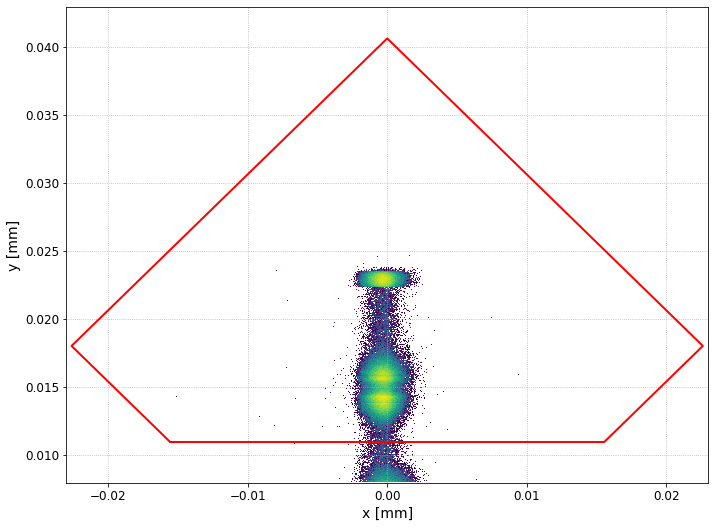

(1500, 1500)

In [ ]:
h_TFT = get_TFT_array(df_TFT, show_plot=True)[0]
h_TFT.shape

Retrieved bin width (X): [5.5e-05 0.0e+00]
Retrieved bin width (Y): [5.5e-05 0.0e+00]


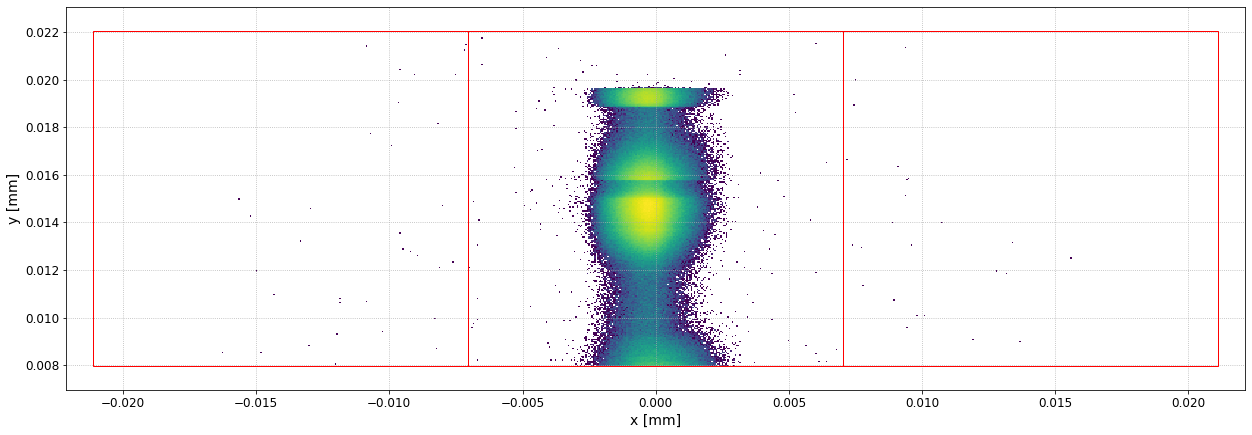

(768, 256)

In [47]:
h_PIX = get_PIX_array(df_PIX, show_plot=True)[0]
h_PIX.shape

In [80]:
TFT_data_to_plot = h_TFT
PIX_data_to_plot = h_PIX
print("TFT_data_to_plot shape: ", TFT_data_to_plot.shape)
print("PIX_data_to_plot shape: ", PIX_data_to_plot.shape)

TFT_data_to_plot shape:  (1500, 1500)
PIX_data_to_plot shape:  (768, 256)


Text(0, 0.5, 'y [mm]')

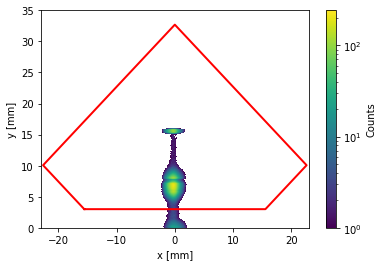

In [81]:
def get_pentagonal(y_lim = 0.003):
    angles = [180-135, 90, 90, 90,135] 
    side_lengths = [31.1e-3, 10e-3, 32e-3, 32e-3, 10e-3]  
    angles = np.radians(angles)

    ALFA_x = [0]
    ALFA_y = [0]
    for i in range(len(side_lengths)):
        angle_sum = np.sum(angles[:i])
        ALFA_x.append(ALFA_x[-1] + side_lengths[i] * np.cos(angle_sum))
        ALFA_y.append(ALFA_y[-1] + side_lengths[i] * np.sin(angle_sum))
    ALFA_x.append(ALFA_x[0])
    ALFA_y.append(ALFA_y[0])

    ALFA_x = [i -side_lengths[0]/2 for i in ALFA_x]
    ALFA_y = [i + y_lim for i in ALFA_y]

    return np.array(ALFA_x), np.array(ALFA_y)

fig, ax = plt.subplots()
xlim = (-23.0, 23.0)
ylim = (0.0, 35.0)
ALFA_x, ALFA_y = get_pentagonal()
ax.plot(ALFA_x*1e3, ALFA_y*1e3, color='r', lw=2)
cmap = plt.cm.viridis.copy()  
cmap.set_under('white')
norm = matplotlib.colors.LogNorm()

plt.imshow(TFT_data_to_plot.T, origin='lower', cmap=cmap, norm = norm,  extent=[xlim[0], xlim[1], ylim[0], ylim[1]], aspect='auto')  
plt.colorbar(label='Counts')
ax.set_xlabel('x [mm]')
ax.set_ylabel('y [mm]')

In [82]:
np.sum(TFT_data_to_plot)

1105683.0

In [83]:
len(df_TFT)

1123916

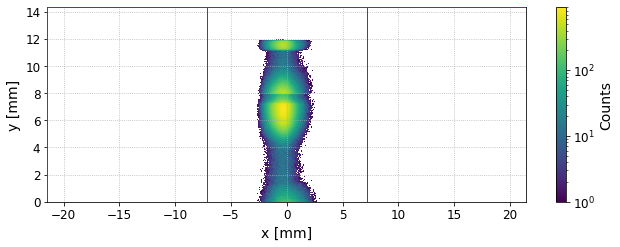

In [84]:
fig, ax = plt.subplots(figsize=(21.45/2,14.30/4))
def plot_rectangle( ax, x_low, x_up, y_low, y_up, zorder = 100, linewidth = 1, edgecolor = 'r', facecolor='none', alpha=1):
    rect = matplotlib.patches.Rectangle((x_low, y_low), x_up - x_low, y_up - y_low, edgecolor=edgecolor, facecolor=facecolor, alpha = alpha, zorder=zorder, linewidth=linewidth)
    ax.add_patch(rect)

ydim = 14.30
xdim = 21.45*2
abs_y_low =  0
abs_y_up = abs_y_low + ydim
abs_x_low = -xdim/2
abs_x_up = xdim/2
vmax, vmin = None, None
plot_rectangle(ax, abs_x_low, abs_x_low + xdim/3, abs_y_low, abs_y_up)
plot_rectangle(ax, abs_x_low + xdim/3, abs_x_low + xdim/3*2, abs_y_low, abs_y_up)
plot_rectangle(ax, abs_x_low + xdim/3*2, abs_x_up, abs_y_low, abs_y_up)

xlim = (-21.45, 21.45)
ylim = (0.0, 14.30)
cmap = plt.cm.viridis.copy()  
cmap.set_under('white')
norm = matplotlib.colors.LogNorm()
plt.imshow(PIX_data_to_plot.T, origin='lower', cmap=cmap, norm=norm, extent=[xlim[0], xlim[1], ylim[0], ylim[1]], aspect='auto')
cbar = plt.colorbar(ax=ax)
cbar.ax.tick_params(labelsize=12)
cbar.set_label(label='Counts', fontsize=14)
ax.set_xlabel('x [mm]', fontsize=14)
ax.set_ylabel('y [mm]', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.grid(linestyle=":")

In [74]:
print(np.sum(PIX_data_to_plot))
print(len(df_PIX))

1132452.0
1132550


# In Beam

In [88]:
dc_files_path  = "./Outputdata/"

file_names_output = subprocess.check_output("ls " + dc_files_path, shell=True).decode('ascii').strip()


file_names_list = file_names_output.split()

path_list = []

for file_name in file_names_list:
    if file_name.startswith("InBeam"):
        file_path = os.path.join(dc_files_path, file_name)
        if os.path.exists(file_path):  
            path_list.append(file_path)

print(path_list) 
print("Number of files: ", len(path_list))

['./Outputdata/InBeam_450_TCCS_0.0.h5', './Outputdata/InBeam_450_TCCS_-11.0.h5', './Outputdata/InBeam_450_TCCS_11.0.h5', './Outputdata/InBeam_450_TCCS_-13.2.h5', './Outputdata/InBeam_450_TCCS_13.2.h5', './Outputdata/InBeam_450_TCCS_-15.4.h5', './Outputdata/InBeam_450_TCCS_15.4.h5', './Outputdata/InBeam_450_TCCS_-17.6.h5', './Outputdata/InBeam_450_TCCS_17.6.h5', './Outputdata/InBeam_450_TCCS_-19.8.h5', './Outputdata/InBeam_450_TCCS_19.8.h5', './Outputdata/InBeam_450_TCCS_-22.0.h5', './Outputdata/InBeam_450_TCCS_22.0.h5', './Outputdata/InBeam_450_TCCS_-2.2.h5', './Outputdata/InBeam_450_TCCS_2.2.h5', './Outputdata/InBeam_450_TCCS_-24.2.h5', './Outputdata/InBeam_450_TCCS_24.2.h5', './Outputdata/InBeam_450_TCCS_-26.4.h5', './Outputdata/InBeam_450_TCCS_-4.4.h5', './Outputdata/InBeam_450_TCCS_4.4.h5', './Outputdata/InBeam_450_TCCS_-6.6.h5', './Outputdata/InBeam_450_TCCS_6.6.h5', './Outputdata/InBeam_450_TCCS_-8.8.h5', './Outputdata/InBeam_450_TCCS_8.8.h5']
Number of files:  24


In [96]:
file_path[0]

'.'

In [97]:
df_TFT = pd.read_hdf(path_list[0], key="TFT_data")
df_PIX = pd.read_hdf(path_list[0], key="PIXEL_data")
metadata = pd.read_hdf(path_list[0], key="metadata")

Retrieved bin width (X): [5.5e-05 0.0e+00]
Retrieved bin width (Y): [5.5e-05 0.0e+00]


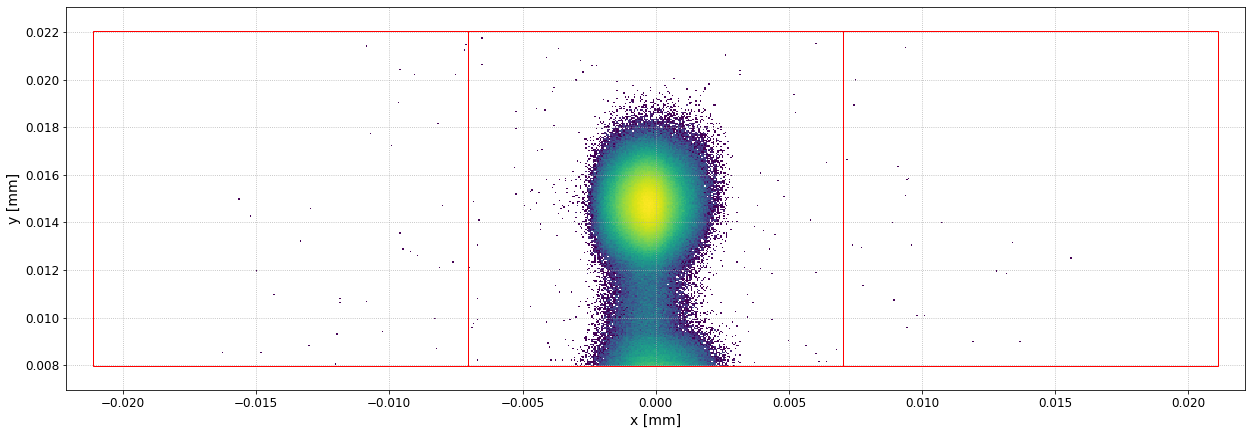

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [98]:
get_PIX_array(df_PIX, show_plot=True)[0]

Retrieved bin width (X): [3.06666667e-05 0.00000000e+00]
Retrieved bin width (Y): [3.06666667e-05 0.00000000e+00]


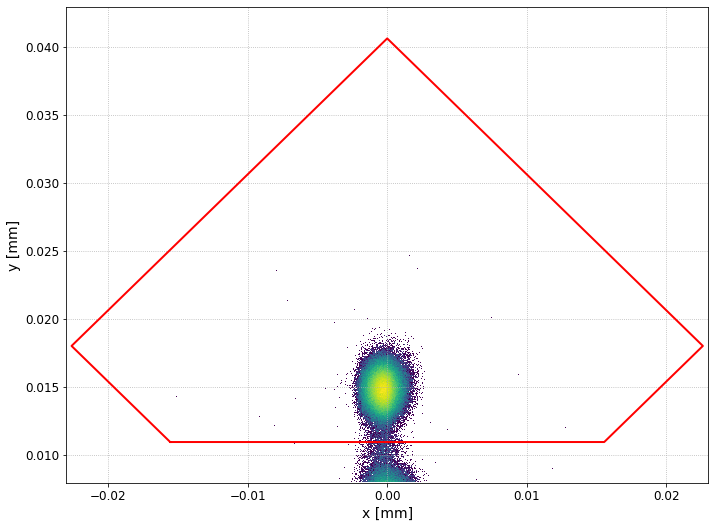

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [99]:
get_TFT_array(df_TFT, show_plot=True)[0]

In [100]:
metadata

,TCCS_align_angle,TCCS_absorbed
0,-0.000046,3222


In [101]:
output_hdf_path = "./TCCS_inBeam_450GeV_ANGSCAN.h5"
with pd.HDFStore(output_hdf_path, mode='w', complevel=9, complib='blosc') as store:
    for file_path in path_list:
        key = float(file_path.split("TCCS_")[1].split(".h5")[0])

        store_key = f"{str(key)}"
        print(f"Processing key: {key} → {store_key}")

        # Read data
        df_TFT = pd.read_hdf(file_path, key="TFT_data")
        df_PIX = pd.read_hdf(file_path, key="PIXEL_data")
        metadata = pd.read_hdf(file_path, key="metadata")
        TCCS_align_angle = metadata["TCCS_align_angle"].iloc[0]
        TCCS_absorbed = metadata["TCCS_absorbed"].iloc[0]

        # Compute arrays
        h_PIX = get_PIX_array(df_PIX, show_plot=False)[0]
        h_TFT = get_TFT_array(df_TFT, show_plot=False)[0]

        # Store arrays directly as DataFrames
        store.put(f"{store_key}/h_PIX", pd.DataFrame(h_PIX), format='table')
        store.put(f"{store_key}/h_TFT", pd.DataFrame(h_TFT), format='table')

        # Store scalar values as a one-row DataFrame
        scalars_df = pd.DataFrame({
            "TCCS_align_angle": [TCCS_align_angle],
            "TCCS_absorbed": [TCCS_absorbed]
        })
        store.put(f"{store_key}/metadata", scalars_df, format='table')

Processing key: 0.0 → 0.0
Retrieved bin width (X): [5.5e-05 0.0e+00]
Retrieved bin width (Y): [5.5e-05 0.0e+00]
Retrieved bin width (X): [3.06666667e-05 0.00000000e+00]
Retrieved bin width (Y): [3.06666667e-05 0.00000000e+00]
Processing key: -11.0 → -11.0


/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '0.0'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


Retrieved bin width (X): [5.5e-05 0.0e+00]
Retrieved bin width (Y): [5.5e-05 0.0e+00]
Retrieved bin width (X): [3.06666667e-05 0.00000000e+00]
Retrieved bin width (Y): [3.06666667e-05 0.00000000e+00]
Processing key: 11.0 → 11.0


/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '-11.0'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


Retrieved bin width (X): [5.5e-05 0.0e+00]
Retrieved bin width (Y): [5.5e-05 0.0e+00]
Retrieved bin width (X): [3.06666667e-05 0.00000000e+00]
Retrieved bin width (Y): [3.06666667e-05 0.00000000e+00]
Processing key: -13.2 → -13.2


/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '11.0'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


Retrieved bin width (X): [5.5e-05 0.0e+00]
Retrieved bin width (Y): [5.5e-05 0.0e+00]
Retrieved bin width (X): [3.06666667e-05 0.00000000e+00]
Retrieved bin width (Y): [3.06666667e-05 0.00000000e+00]
Processing key: 13.2 → 13.2


/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '-13.2'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


Retrieved bin width (X): [5.5e-05 0.0e+00]
Retrieved bin width (Y): [5.5e-05 0.0e+00]
Retrieved bin width (X): [3.06666667e-05 0.00000000e+00]
Retrieved bin width (Y): [3.06666667e-05 0.00000000e+00]
Processing key: -15.4 → -15.4


/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '13.2'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


Retrieved bin width (X): [5.5e-05 0.0e+00]
Retrieved bin width (Y): [5.5e-05 0.0e+00]
Retrieved bin width (X): [3.06666667e-05 0.00000000e+00]
Retrieved bin width (Y): [3.06666667e-05 0.00000000e+00]
Processing key: 15.4 → 15.4


/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '-15.4'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


Retrieved bin width (X): [5.5e-05 0.0e+00]
Retrieved bin width (Y): [5.5e-05 0.0e+00]
Retrieved bin width (X): [3.06666667e-05 0.00000000e+00]
Retrieved bin width (Y): [3.06666667e-05 0.00000000e+00]
Processing key: -17.6 → -17.6


/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '15.4'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


Retrieved bin width (X): [5.5e-05 0.0e+00]
Retrieved bin width (Y): [5.5e-05 0.0e+00]
Retrieved bin width (X): [3.06666667e-05 0.00000000e+00]
Retrieved bin width (Y): [3.06666667e-05 0.00000000e+00]
Processing key: 17.6 → 17.6


/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '-17.6'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


Retrieved bin width (X): [5.5e-05 0.0e+00]
Retrieved bin width (Y): [5.5e-05 0.0e+00]
Retrieved bin width (X): [3.06666667e-05 0.00000000e+00]
Retrieved bin width (Y): [3.06666667e-05 0.00000000e+00]
Processing key: -19.8 → -19.8


/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '17.6'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


Retrieved bin width (X): [5.5e-05 0.0e+00]
Retrieved bin width (Y): [5.5e-05 0.0e+00]
Retrieved bin width (X): [3.06666667e-05 0.00000000e+00]
Retrieved bin width (Y): [3.06666667e-05 0.00000000e+00]
Processing key: 19.8 → 19.8


/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '-19.8'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


Retrieved bin width (X): [5.5e-05 0.0e+00]
Retrieved bin width (Y): [5.5e-05 0.0e+00]
Retrieved bin width (X): [3.06666667e-05 0.00000000e+00]
Retrieved bin width (Y): [3.06666667e-05 0.00000000e+00]
Processing key: -22.0 → -22.0


/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '19.8'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


Retrieved bin width (X): [5.5e-05 0.0e+00]
Retrieved bin width (Y): [5.5e-05 0.0e+00]
Retrieved bin width (X): [3.06666667e-05 0.00000000e+00]
Retrieved bin width (Y): [3.06666667e-05 0.00000000e+00]
Processing key: 22.0 → 22.0


/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '-22.0'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


Retrieved bin width (X): [5.5e-05 0.0e+00]
Retrieved bin width (Y): [5.5e-05 0.0e+00]
Retrieved bin width (X): [3.06666667e-05 0.00000000e+00]
Retrieved bin width (Y): [3.06666667e-05 0.00000000e+00]
Processing key: -2.2 → -2.2


/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '22.0'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


Retrieved bin width (X): [5.5e-05 0.0e+00]
Retrieved bin width (Y): [5.5e-05 0.0e+00]
Retrieved bin width (X): [3.06666667e-05 0.00000000e+00]
Retrieved bin width (Y): [3.06666667e-05 0.00000000e+00]
Processing key: 2.2 → 2.2


/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '-2.2'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


Retrieved bin width (X): [5.5e-05 0.0e+00]
Retrieved bin width (Y): [5.5e-05 0.0e+00]
Retrieved bin width (X): [3.06666667e-05 0.00000000e+00]
Retrieved bin width (Y): [3.06666667e-05 0.00000000e+00]
Processing key: -24.2 → -24.2


/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '2.2'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


Retrieved bin width (X): [5.5e-05 0.0e+00]
Retrieved bin width (Y): [5.5e-05 0.0e+00]
Retrieved bin width (X): [3.06666667e-05 0.00000000e+00]
Retrieved bin width (Y): [3.06666667e-05 0.00000000e+00]
Processing key: 24.2 → 24.2


/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '-24.2'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


Retrieved bin width (X): [5.5e-05 0.0e+00]
Retrieved bin width (Y): [5.5e-05 0.0e+00]
Retrieved bin width (X): [3.06666667e-05 0.00000000e+00]
Retrieved bin width (Y): [3.06666667e-05 0.00000000e+00]
Processing key: -26.4 → -26.4


/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '24.2'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


Retrieved bin width (X): [5.5e-05 0.0e+00]
Retrieved bin width (Y): [5.5e-05 0.0e+00]
Retrieved bin width (X): [3.06666667e-05 0.00000000e+00]
Retrieved bin width (Y): [3.06666667e-05 0.00000000e+00]
Processing key: -4.4 → -4.4


/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '-26.4'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


Retrieved bin width (X): [5.5e-05 0.0e+00]
Retrieved bin width (Y): [5.5e-05 0.0e+00]
Retrieved bin width (X): [3.06666667e-05 0.00000000e+00]
Retrieved bin width (Y): [3.06666667e-05 0.00000000e+00]
Processing key: 4.4 → 4.4


/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '-4.4'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


Retrieved bin width (X): [5.5e-05 0.0e+00]
Retrieved bin width (Y): [5.5e-05 0.0e+00]
Retrieved bin width (X): [3.06666667e-05 0.00000000e+00]
Retrieved bin width (Y): [3.06666667e-05 0.00000000e+00]
Processing key: -6.6 → -6.6


/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '4.4'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


Retrieved bin width (X): [5.5e-05 0.0e+00]
Retrieved bin width (Y): [5.5e-05 0.0e+00]
Retrieved bin width (X): [3.06666667e-05 0.00000000e+00]
Retrieved bin width (Y): [3.06666667e-05 0.00000000e+00]
Processing key: 6.6 → 6.6


/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '-6.6'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


Retrieved bin width (X): [5.5e-05 0.0e+00]
Retrieved bin width (Y): [5.5e-05 0.0e+00]
Retrieved bin width (X): [3.06666667e-05 0.00000000e+00]
Retrieved bin width (Y): [3.06666667e-05 0.00000000e+00]
Processing key: -8.8 → -8.8


/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '6.6'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


Retrieved bin width (X): [5.5e-05 0.0e+00]
Retrieved bin width (Y): [5.5e-05 0.0e+00]
Retrieved bin width (X): [3.06666667e-05 0.00000000e+00]
Retrieved bin width (Y): [3.06666667e-05 0.00000000e+00]
Processing key: 8.8 → 8.8


/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '-8.8'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


Retrieved bin width (X): [5.5e-05 0.0e+00]
Retrieved bin width (Y): [5.5e-05 0.0e+00]
Retrieved bin width (X): [3.06666667e-05 0.00000000e+00]
Retrieved bin width (Y): [3.06666667e-05 0.00000000e+00]


/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '8.8'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


In [94]:
keys = [0.0, -11.0, 11.0, -13.2, 13.2, -15.4, 15.4, -17.6, 17.6, -19.8, 19.8, -22.0, 22.0, -2.2, 2.2, -24.2, 24.2, -26.4, -4.4, 4.4, -6.6, 6.6, -8.8, 8.8]

In [102]:
with pd.HDFStore(output_hdf_path, mode='r') as store:
    key = 11.0
  
    h_PIX = store[f"{key}/h_PIX"].values
    h_TFT = store[f"{key}/h_TFT"].values

    metadata = store[f"{key}/metadata"]
    TCCS_align_angle = metadata["TCCS_align_angle"].iloc[0]
    TCCS_absorbed = metadata["TCCS_absorbed"].iloc[0]

In [105]:
PIX_data_to_plot = h_PIX
TFT_data_to_plot = h_TFT

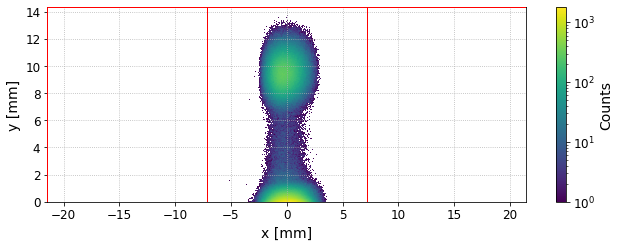

In [106]:
fig, ax = plt.subplots(figsize=(21.45/2,14.30/4))
def plot_rectangle( ax, x_low, x_up, y_low, y_up, zorder = 100, linewidth = 1, edgecolor = 'r', facecolor='none', alpha=1):
    rect = matplotlib.patches.Rectangle((x_low, y_low), x_up - x_low, y_up - y_low, edgecolor=edgecolor, facecolor=facecolor, alpha = alpha, zorder=zorder, linewidth=linewidth)
    ax.add_patch(rect)

ydim = 14.30
xdim = 21.45*2
abs_y_low =  0
abs_y_up = abs_y_low + ydim
abs_x_low = -xdim/2
abs_x_up = xdim/2
vmax, vmin = None, None
plot_rectangle(ax, abs_x_low, abs_x_low + xdim/3, abs_y_low, abs_y_up)
plot_rectangle(ax, abs_x_low + xdim/3, abs_x_low + xdim/3*2, abs_y_low, abs_y_up)
plot_rectangle(ax, abs_x_low + xdim/3*2, abs_x_up, abs_y_low, abs_y_up)

xlim = (-21.45, 21.45)
ylim = (0.0, 14.30)
cmap = plt.cm.viridis.copy()  
cmap.set_under('white')
norm = matplotlib.colors.LogNorm()
plt.imshow(PIX_data_to_plot.T, origin='lower', cmap=cmap, norm=norm, extent=[xlim[0], xlim[1], ylim[0], ylim[1]], aspect='auto')
cbar = plt.colorbar(ax=ax)
cbar.ax.tick_params(labelsize=12)
cbar.set_label(label='Counts', fontsize=14)
ax.set_xlabel('x [mm]', fontsize=14)
ax.set_ylabel('y [mm]', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.grid(linestyle=":")

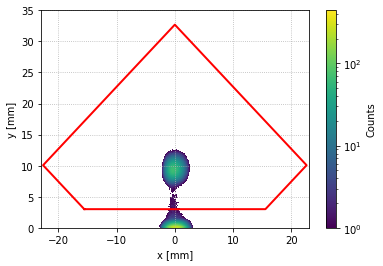

In [108]:
def get_pentagonal(y_lim = 0.003):
    angles = [180-135, 90, 90, 90,135] 
    side_lengths = [31.1e-3, 10e-3, 32e-3, 32e-3, 10e-3]  
    angles = np.radians(angles)

    ALFA_x = [0]
    ALFA_y = [0]
    for i in range(len(side_lengths)):
        angle_sum = np.sum(angles[:i])
        ALFA_x.append(ALFA_x[-1] + side_lengths[i] * np.cos(angle_sum))
        ALFA_y.append(ALFA_y[-1] + side_lengths[i] * np.sin(angle_sum))
    ALFA_x.append(ALFA_x[0])
    ALFA_y.append(ALFA_y[0])

    ALFA_x = [i -side_lengths[0]/2 for i in ALFA_x]
    ALFA_y = [i + y_lim for i in ALFA_y]

    return np.array(ALFA_x), np.array(ALFA_y)

fig, ax = plt.subplots()
xlim = (-23.0, 23.0)
ylim = (0.0, 35.0)
ALFA_x, ALFA_y = get_pentagonal()
ax.plot(ALFA_x*1e3, ALFA_y*1e3, color='r', lw=2)
cmap = plt.cm.viridis.copy()  
cmap.set_under('white')
norm = matplotlib.colors.LogNorm()

plt.imshow(TFT_data_to_plot.T, origin='lower', cmap=cmap, norm = norm,  extent=[xlim[0], xlim[1], ylim[0], ylim[1]], aspect='auto')  
plt.colorbar(label='Counts')
ax.set_xlabel('x [mm]')
ax.set_ylabel('y [mm]')
ax.grid(linestyle=":")

# TCLA abs

In [16]:
df = pd.read_hdf("./Outputdata/Double_Channeling_450_ABSORBED_2.h5", key = "absorbed" )

In [17]:
df

,delta_angle_TCCP,TCCS_abs,TCCP_abs,TCLA_abs,PIPE_abs,TCCP_angle,npart,n_impacts
0,-0.0,3222,83176,546692,287605,0.000170,2000000,1132550
1,-1.1,3221,82947,545438,289829,0.000169,2000000,1132776
2,-11.0,3221,93402,602041,198523,0.000159,2000000,1122326
3,-12.1,3221,96156,614684,175470,0.000158,2000000,1119575
4,-13.2,3222,99183,627341,151734,0.000156,2000000,1116544
5,-14.3,3221,101989,639399,128532,0.000155,2000000,1113744
6,-15.4,3222,104838,650678,105843,0.000154,2000000,1110901
7,-16.5,3221,107630,661117,84379,0.000153,2000000,1108109
8,-17.6,3223,110173,670657,64496,0.000152,2000000,1105571
9,-18.7,3221,112299,678953,46536,0.000151,2000000,1103453


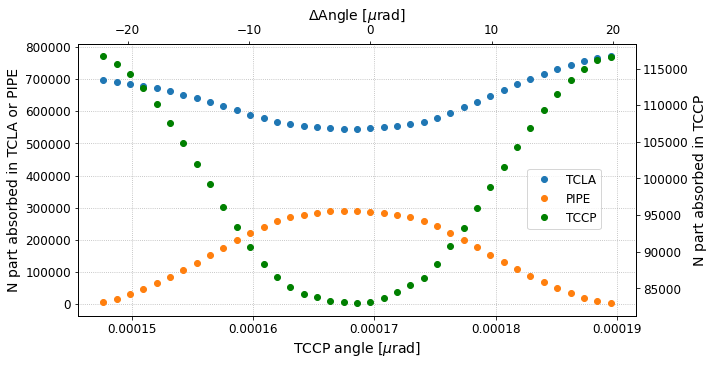

In [49]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(df.TCCP_angle, df.TCLA_abs, 'o', label = "TCLA")
ax.plot(df.TCCP_angle, df.PIPE_abs, 'o', label = "PIPE")
ax2 = ax.twinx()
ax2.plot(df.TCCP_angle, df.TCCP_abs, 'o', color = "green", label = "TCCP")
ax2.set_ylabel("N part absorbed in TCCP", fontsize=14)
ax.set_xlabel("TCCP angle [$\mu$rad]", fontsize=14)
ax.set_ylabel("N part absorbed in TCLA or PIPE", fontsize=14)
ax3  = ax.twiny()
ax3.plot(df.delta_angle_TCCP, df.TCLA_abs, 'o', alpha=0)
ax3.set_xlabel("$\Delta$Angle [$\mu$rad]", fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
ax2.tick_params(axis='both', which='major', labelsize=12)
ax3.tick_params(axis='both', which='major', labelsize=12)
# Get handles and labels for both axes' legends
handles1, labels1 = ax.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
fig.legend(handles1 + handles2, labels1 + labels2, loc='upper center', fontsize=12,  bbox_to_anchor=(0.80, 0.55))
ax.grid(linestyle=":")



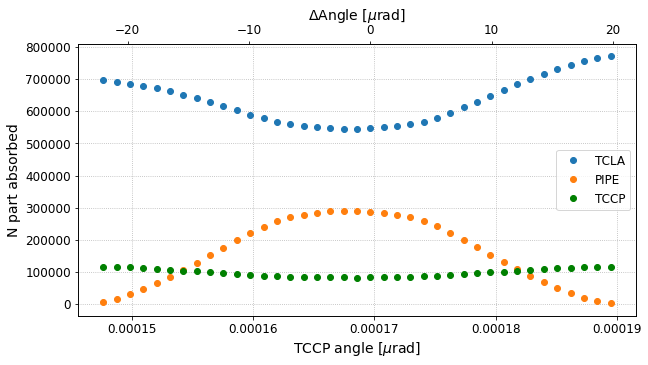

In [54]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(df.TCCP_angle, df.TCLA_abs, 'o', label = "TCLA")
ax.plot(df.TCCP_angle, df.PIPE_abs, 'o', label = "PIPE")

ax.plot(df.TCCP_angle, df.TCCP_abs, 'o', color = "green", label = "TCCP")

ax.set_xlabel("TCCP angle [$\mu$rad]", fontsize=14)
ax.set_ylabel("N part absorbed", fontsize=14)
ax3  = ax.twiny()
ax3.plot(df.delta_angle_TCCP, df.TCLA_abs, 'o', alpha=0)
ax3.set_xlabel("$\Delta$Angle [$\mu$rad]", fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)

ax3.tick_params(axis='both', which='major', labelsize=12)
ax.legend(fontsize=12)
ax.grid(linestyle=":")

# Test New Script

In [4]:
file_name =  "./DoubleChanneling_450GeV_ANGSCAN_ROT2.2murad.h5"

In [5]:
with pd.HDFStore(file_name, mode='r') as f:
        print("Top-level keys:")
        for key in f.keys():
            print(key)

Top-level keys:
/9.9/h_PIX
/9.9/h_TFT
/7.7/h_PIX
/7.7/h_TFT
/5.5/h_PIX
/5.5/h_TFT
/3.3/h_PIX
/3.3/h_TFT
/18.7/h_PIX
/18.7/h_TFT
/16.5/h_PIX
/16.5/h_TFT
/14.3/h_PIX
/14.3/h_TFT
/12.1/h_PIX
/12.1/h_TFT
/1.1/h_PIX
/1.1/h_TFT
/0.0/h_PIX
/0.0/h_TFT
/-9.9/h_PIX
/-9.9/h_TFT
/-7.7/h_PIX
/-7.7/h_TFT
/-5.5/h_PIX
/-5.5/h_TFT
/-3.3/h_PIX
/-3.3/h_TFT
/-20.9/h_PIX
/-20.9/h_TFT
/-18.7/h_PIX
/-18.7/h_TFT
/-16.5/h_PIX
/-16.5/h_TFT
/-14.3/h_PIX
/-14.3/h_TFT
/-12.1/h_PIX
/-12.1/h_TFT
/-1.1/h_PIX
/-1.1/h_TFT


In [6]:
with pd.HDFStore(file_name, mode='r') as store:
    key = 0.0
  
    h_PIX = store[f"{key}/h_PIX"].values
    h_TFT = store[f"{key}/h_TFT"].values



In [7]:
PIX_data_to_plot = h_PIX
TFT_data_to_plot = h_TFT

In [8]:
np.sum(PIX_data_to_plot)

1129599.0

In [9]:
np.sum(TFT_data_to_plot)

1121091.0

Text(0, 0.5, 'y [mm]')

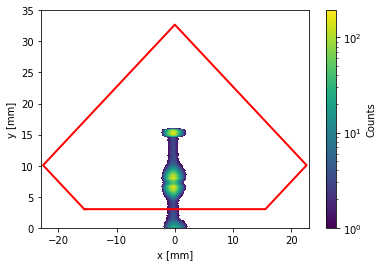

In [10]:
def get_pentagonal(y_lim = 0.003):
    angles = [180-135, 90, 90, 90,135] 
    side_lengths = [31.1e-3, 10e-3, 32e-3, 32e-3, 10e-3]  
    angles = np.radians(angles)

    ALFA_x = [0]
    ALFA_y = [0]
    for i in range(len(side_lengths)):
        angle_sum = np.sum(angles[:i])
        ALFA_x.append(ALFA_x[-1] + side_lengths[i] * np.cos(angle_sum))
        ALFA_y.append(ALFA_y[-1] + side_lengths[i] * np.sin(angle_sum))
    ALFA_x.append(ALFA_x[0])
    ALFA_y.append(ALFA_y[0])

    ALFA_x = [i -side_lengths[0]/2 for i in ALFA_x]
    ALFA_y = [i + y_lim for i in ALFA_y]

    return np.array(ALFA_x), np.array(ALFA_y)

fig, ax = plt.subplots()
xlim = (-23.0, 23.0)
ylim = (0.0, 35.0)
ALFA_x, ALFA_y = get_pentagonal()
ax.plot(ALFA_x*1e3, ALFA_y*1e3, color='r', lw=2)
cmap = plt.cm.viridis.copy()  
cmap.set_under('white')
norm = matplotlib.colors.LogNorm()

plt.imshow(TFT_data_to_plot.T, origin='lower', cmap=cmap, norm = norm,  extent=[xlim[0], xlim[1], ylim[0], ylim[1]], aspect='auto')  
plt.colorbar(label='Counts')
ax.set_xlabel('x [mm]')
ax.set_ylabel('y [mm]')

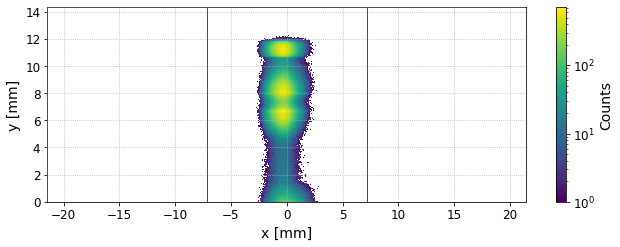

In [11]:
fig, ax = plt.subplots(figsize=(21.45/2,14.30/4))
def plot_rectangle( ax, x_low, x_up, y_low, y_up, zorder = 100, linewidth = 1, edgecolor = 'r', facecolor='none', alpha=1):
    rect = matplotlib.patches.Rectangle((x_low, y_low), x_up - x_low, y_up - y_low, edgecolor=edgecolor, facecolor=facecolor, alpha = alpha, zorder=zorder, linewidth=linewidth)
    ax.add_patch(rect)

ydim = 14.30
xdim = 21.45*2
abs_y_low =  0
abs_y_up = abs_y_low + ydim
abs_x_low = -xdim/2
abs_x_up = xdim/2
vmax, vmin = None, None
plot_rectangle(ax, abs_x_low, abs_x_low + xdim/3, abs_y_low, abs_y_up)
plot_rectangle(ax, abs_x_low + xdim/3, abs_x_low + xdim/3*2, abs_y_low, abs_y_up)
plot_rectangle(ax, abs_x_low + xdim/3*2, abs_x_up, abs_y_low, abs_y_up)

xlim = (-21.45, 21.45)
ylim = (0.0, 14.30)
cmap = plt.cm.viridis.copy()  
cmap.set_under('white')
norm = matplotlib.colors.LogNorm()
plt.imshow(PIX_data_to_plot.T, origin='lower', cmap=cmap, norm=norm, extent=[xlim[0], xlim[1], ylim[0], ylim[1]], aspect='auto')
cbar = plt.colorbar(ax=ax)
cbar.ax.tick_params(labelsize=12)
cbar.set_label(label='Counts', fontsize=14)
ax.set_xlabel('x [mm]', fontsize=14)
ax.set_ylabel('y [mm]', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.grid(linestyle=":")

In [12]:
df = pd.read_hdf("./Outputdata/Double_Channeling_450_ABSORBED_ROT2.2murad.h5", key = "absorbed" )

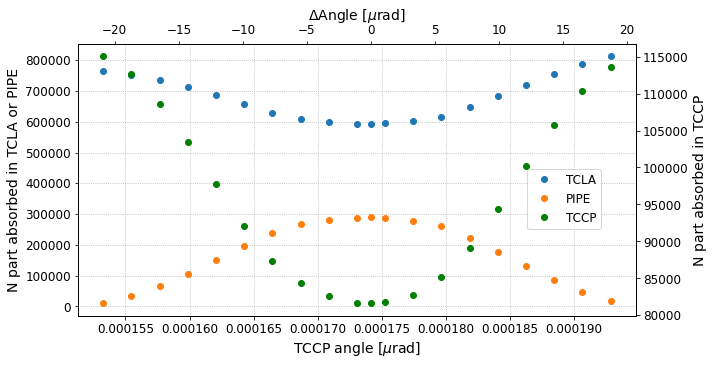

In [13]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(df.TCCP_angle, df.TCLA_abs, 'o', label = "TCLA")
ax.plot(df.TCCP_angle, df.PIPE_abs, 'o', label = "PIPE")
ax2 = ax.twinx()
ax2.plot(df.TCCP_angle, df.TCCP_abs, 'o', color = "green", label = "TCCP")
ax2.set_ylabel("N part absorbed in TCCP", fontsize=14)
ax.set_xlabel("TCCP angle [$\mu$rad]", fontsize=14)
ax.set_ylabel("N part absorbed in TCLA or PIPE", fontsize=14)
ax3  = ax.twiny()
ax3.plot(df.delta_angle_TCCP, df.TCLA_abs, 'o', alpha=0)
ax3.set_xlabel("$\Delta$Angle [$\mu$rad]", fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
ax2.tick_params(axis='both', which='major', labelsize=12)
ax3.tick_params(axis='both', which='major', labelsize=12)
# Get handles and labels for both axes' legends
handles1, labels1 = ax.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
fig.legend(handles1 + handles2, labels1 + labels2, loc='upper center', fontsize=12,  bbox_to_anchor=(0.80, 0.55))
ax.grid(linestyle=":")


# Add 0 

In [12]:
import json
import os
import subprocess
import glob

import numpy as np
from pathlib import Path
import yaml
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd

from matplotlib.ticker import MaxNLocator
import lossmaps as lm
import xobjects as xo

import xtrack as xt
import xcoll as xc

import lossmaps as lm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import xarray as xr

import json
import copy

import xtrack as xt
import xpart as xp
import xobjects as xo


import pickle 
import h5py
import io
import scipy
from scipy.optimize import curve_fit

import ast

from scipy.special import erf
import scipy.optimize as opt
from matplotlib.ticker import FixedLocator
from scipy.stats import norm

import uproot 
from IPython import embed

import re


# ---------------------------- SIMULATION CHECKING FUNCTIONS ----------------------------
def ls(return_list = False, path="/eos/home-c/cmaccani/xsuite_sim/two_cryst_sim/Condor/"):
    if return_list:
        return subprocess.check_output("ls -ht " + path, shell=True).decode('ascii').strip().split('\n')
    else:
        print(subprocess.check_output("ls -ht " + path, shell=True).decode('ascii').strip())

def get_simulation_output(folder, path="/afs/cern.ch/work/c/cmaccani/xsuite_sim/twocryst_sim/Condor/",file_name="htcondor*.out", print_1=True, n=0):
    try:
        file_content = subprocess.check_output("cat " + path + folder + f'/Job.{n}/' + file_name, shell=True).decode('ascii').strip()
    except:
        print('File not found at: ' + path + folder + f'/Job.{n}/' + file_name)
        return
    if print_1:
        print(file_content)
    else:
        return file_content

def get_analysis_init(folder, suffix='' , path="/afs/cern.ch/work/c/cmaccani/xsuite_sim/twocryst_sim/Condor/", file_name="htcondor*.out", n=0, only_sim_obj = True):
    file_lines = get_simulation_output(folder, print_1=False, path = path, n=n).split('\n')
    if only_sim_obj:
        file_pattern = os.path.join(path, folder, 'input_cache', 'config_sim*.yaml')
        matching_files = glob.glob(file_pattern)
        if matching_files:
            with open(matching_files[0], 'r') as file:
                config = yaml.load(file, Loader=yaml.FullLoader)
                obj_list = config['run']['save_list']

    for i in range(len(file_lines)):
        if 'CrystalAnalysis' in file_lines[i] or 'TargetAnalysis' in file_lines[i]:
            if file_lines[i-1] in ['TCCS', 'TCCP', 'TARGET', 'PIXEL', 'TCP', 'BLM', 'TCLA', 'TFT']:
                if only_sim_obj:
                    if any([file_lines[i-1] in obj for obj in obj_list]):
                        print(file_lines[i-1]+suffix+' = '+file_lines[i])
                else:    
                    print(file_lines[i-1]+suffix+' = '+file_lines[i])
            else:    
                print('OBJ'+suffix+' = '+file_lines[i])



def check_config(folder, path="/afs/cern.ch/work/c/cmaccani/xsuite_sim/twocryst_sim/Condor/", cat=['run']):
    file_pattern = os.path.join(path, folder, 'input_cache', 'config_sim*.yaml')
    matching_files = glob.glob(file_pattern)
    if matching_files:
        with open(matching_files[0], 'r') as file:
            config = yaml.load(file, Loader=yaml.FullLoader)
    for c in cat:
        print(config[c])


def check_hdf_keys(input_path):
    with pd.HDFStore(input_path, 'r') as store:
         keys = store.keys()
    for key in keys:
        print(key)


def display_rows(rows = None, cols = None):
    pd.set_option('display.max_rows', rows)
    pd.set_option('display.max_columns', cols)


def gaussian(x, A, mu, sigma):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))

def erfunc(x,a,b,c,d):
    return a+(b/2.0)*erf((x-c)/(d*np.sqrt(2.0)))
    
def normalize_histograms(ax, A, mu, sigma, xmin = 0.009, xmax = 0.015):

    def gaussian(x, A, mu, sigma):
        return A * np.exp(-(x - mu)**2 / (2 * sigma**2))

     #ax.get_xlim()
    x = np.linspace(xmin, xmax, 100)

    hist_values = [rect.get_height() for rect in ax.patches]
    bin_edges = [rect.get_x() for rect in ax.patches]
    df = pd.DataFrame({'bin_edges': bin_edges, 'hist_values': hist_values})
    df = df[(df.bin_edges > xmin) & (df.bin_edges < xmax)]
   

    # Calculate the area of the histogram
    bin_widths = np.diff(df.bin_edges)  
    bin_widths = np.append(bin_widths, 0) 
    hist_area = np.sum(df.hist_values * bin_widths)  


    tmp_y = gaussian(x, A, mu, sigma)
    funct_area = np.trapz(tmp_y, x=x)
    new_A = A/funct_area*hist_area
    return new_A, mu, sigma


TCCS_name = 'tccs.5r3.b2'
TCCP_name = 'tccp.4l3.b2'
TARGET_name = 'target.4l3.b2'
PIXEL_name = 'pixel.detector'
TFT_name = 'tft.detector'
TCP_name = 'tcp.d6r7.b2'
TCLA_name = 'tcla.a5l3.b2'

names_list = [TCCS_name, TCCP_name, TARGET_name, PIXEL_name+"_1", TFT_name, TCP_name, TCLA_name]

class ParticleAnalysis():

    def __init__(self, n_sigma, length, sigma, xdim = None, ydim = None, beam = 2, plane = 'V', jaw_L = None, emittance_n = 3.5e-6):

        self.beam = beam
        self.plane = plane
        self.n_sigma = n_sigma
        self.length = length
        self.xdim = xdim
        self.ydim = ydim
        self.sigma = sigma
        if jaw_L is not None:
            self.jaw_L = jaw_L
        else:
            self.jaw_L = sigma * n_sigma
        self.p0c = None
        self.npart = None
        self.data = None
        self.gamma0 = None
        self.beta0 = None
        self.charge = None
        self.mass = None
        self.emittance_n = emittance_n
        self.emittance = None

        if xdim is not None and ydim is not None:
            if self.plane == 'H':
                self.abs_y_low = -self.ydim/2
                self.abs_y_up = self.ydim/2
                self.abs_x_low = self.jaw_L
                self.abs_x_up = self.jaw_L + self.xdim
                self.ref = self.jaw_L - self.n_sigma*self.sigma 

            elif self.plane == 'V':       
                self.abs_y_low = self.jaw_L
                self.abs_y_up = self.jaw_L + self.ydim
                self.abs_x_low = -self.xdim/2
                self.abs_x_up = self.xdim/2
                self.ref = self.jaw_L - self.n_sigma*self.sigma 
        else:
            if self.plane == 'H':
                self.abs_y_low = None
                self.abs_y_up = None
                self.abs_x_low = self.jaw_L
                self.abs_x_up = None
                self.ref = self.jaw_L - self.n_sigma*self.sigma 
            elif self.plane == 'V':       
                self.abs_y_low = self.jaw_L
                self.abs_y_up = None
                self.abs_x_low = None
                self.abs_x_up = None
                self.ref = self.jaw_L - self.n_sigma*self.sigma 

        self.fit = None

        self.n_jobs = None
        self.part_per_job = None
        
        self.lossmap = None 
        self.losses = None

        self.tw = None  

        self.n_CRY_absorbed = None
        self.n_TCCS_absorbed = None
        self.n_TCCP_absorbed = None
        self.n_TCCP_absorbed_xp = None
        self.TCCP_absorbed_xp2 = None
        self.TCCS_sim_chann_eff = None
        self.TCCP_sim_chann_eff = None
        self.CRY_sim_chann_eff = None
        self.TCCP_align_angle = None
        self.TCCS_align_angle = None
        self.TCCP_jaw_U = None
        self.TCCP_jaw_D = None
        self_TCCP_sigma  = None
   
            
            
    def retreive_file_path(self, prefix_name, file_name = 'particle*.h5', path = "/eos/home-c/cmaccani/xsuite_sim/two_cryst_sim/Condor/", Condor = True, n_return = None):
        
        if Condor:
            test_list = [path + i for i in os.listdir(path) if prefix_name in i]
            for test_name in test_list:

                n_jobs = int(subprocess.check_output("find "+ test_name +" -maxdepth 1 -mindepth 1 -type d | grep Job. | wc -l", shell=True))

                path_list =[]

                for i in range(n_jobs):
                    file_path_part = (subprocess.check_output("echo " + test_name + '/Job.' + str(i) + '/Outputdata/' + file_name, shell=True)).decode('ascii').strip()
                    if os.path.exists(file_path_part):
                        path_list.append(file_path_part)

                n_jobs_verify  = len(path_list)
                if n_jobs != n_jobs_verify:
                    print("!!! Succesful Jobs: ", n_jobs_verify, '/', n_jobs, ' in file: ', test_name)
        else:
            path_list = (subprocess.check_output("echo " + path + prefix_name +file_name, shell=True)).decode('ascii').strip()
        
        if not hasattr(path_list, '__iter__') or isinstance(path_list, str):
            path_list = [path_list]

        if n_return is not None:
            return path_list[:n_return]
        else:
            return path_list   
    


    def load_particles(self, path, df_key, Condor=True, 
                       file_name='particle*.h5', 
                       default_path = "/eos/home-c/cmaccani/xsuite_sim/two_cryst_sim/Condor/",
                       n_return = None,
                       part_per_job = 50000,
                       **kwargs):

        h5_file_path = self.retreive_file_path(prefix_name = path, file_name = file_name, path = default_path, Condor=Condor, n_return = n_return)       
        if Condor == True:
            self.part_per_job = part_per_job
            self.n_jobs = len(h5_file_path)

        df_particles = pd.DataFrame()
        npart = 0
        for file in h5_file_path:

            job_id = int(file.split('Job.')[1].split('/')[0]) if Condor else 0
            
            try:
                df_tmp = pd.read_hdf(file, key=df_key) #test_particles_B2V                  
                df_tmp['particle_id'] = df_tmp['particle_id'] + part_per_job*job_id    
                if 'at_element' in df_tmp.columns and df_tmp['at_element'].dtype == 'int32':
                    try:
                        idx_table = pd.read_hdf(file, key='idx').to_dict()[0]
                        df_tmp['at_element'] = df_tmp['at_element'].map(idx_table)
                    except:
                        pass
            
                for col in ['interactions']:
                    if col in df_tmp.columns:
                        df_tmp[col] = df_tmp[col].apply(lambda x:x.split(',') if isinstance(x, str) else x)
                
                for col in ['TCCP_turn', 'TCCS_turn', 'CRY_turn']:
                    if col in df_tmp.columns:
                        df_tmp[col] = df_tmp[col].apply(lambda x:x.split(',') if isinstance(x, str) else x)           
                        df_tmp[col] = df_tmp[col].apply(lambda x: [int(i) if i != 'None' else i for i in x] )
                        df_tmp[col] = df_tmp[col].apply(lambda x: [] if 'None' in x else x)                
                
                TCP_turns = []

                if 'TCP_turn' in df_tmp.columns:
                    for s in df_tmp['TCP_turn']:
                        TCP_turns.append(ast.literal_eval(f'[{s}]') if s != "None" else [[],[],[]]) 
                    df_tmp['TCP_turn'] = TCP_turns
                
                df_particles = pd.concat([df_particles, df_tmp])

            except FileNotFoundError:
                print(f"Error: File not found at {file}")
                continue
            except pd.errors.EmptyDataError:
                print(f"Error: The HDF5 file at {file} is empty.")
                continue
            except Exception as e:
                print(f"Error: An unexpected error occurred - {e}")
                continue
            npart = npart + len(df_tmp)

                  
        self.npart = npart

        if 'p0c' in df_particles.columns:     
            if len(df_particles['p0c'].unique()) == 1:
                p0c = df_particles['p0c'].unique()[0]
            else:
                print('There are particles at different energies')            
            self.p0c = p0c
        else:
            metadata = pd.read_hdf(h5_file_path[0], key='metadata').to_dict()[0]

            self.p0c = metadata['p0c']
            self.gamma0 = metadata['gamma0']
            self.beta0 = metadata['beta0']
            self.charge = metadata['q0']
            self.mass = metadata['mass0']
            self.emittance = self.emittance_n / (self.gamma0 * self.beta0)
            self.TCCP_align_angle = metadata['TCCP_align_angle'] if 'TCCP_align_angle' in metadata.keys() else None
            self.TCCS_align_angle = metadata['TCCS_align_angle'] if 'TCCS_align_angle' in metadata.keys() else None
            self.TCCP_jaw_U = metadata['TCCP_jaw_U'] if 'TCCP_jaw_U' in metadata.keys() else None
            self.TCCP_jaw_D = metadata['TCCP_jaw_D'] if 'TCCP_jaw_D' in metadata.keys() else None
            self.TCCP_sigma = metadata['TCCP_sigma'] if 'TCCP_sigma' in metadata.keys() else None


        return df_particles.reset_index(drop=True)
    
    def impact_part(self, eps=9e-10):
        if self.xdim is None or self.ydim is None:
            if self.plane == 'H':
                hit_mask = self.data['x'] >= self.abs_x_low-eps
            elif self.plane == 'V':
                hit_mask = self.data['y'] >= self.abs_y_low-eps
        else:
            hit_mask = ((self.data['x'] >= self.abs_x_low - eps) & (self.data['x'] <= self.abs_x_up  - eps) & (self.data['y'] >= self.abs_y_low  - eps) & (self.data['y'] <= self.abs_y_up - eps))
        return self.data[hit_mask]   
    
    def get_job_id(self, abs_id, TCCS = None):
        
        if not hasattr(abs_id, '__iter__') or isinstance(abs_id, str):
            abs_id = [abs_id]
        elif isinstance(abs_id, pd.Series):
            abs_id = abs_id.to_list()

        for id in abs_id:
            print(f'\nabs_id: {id}')
            if TCCS is not None:
                df_tccs = TCCS.data
                df_tccs = df_tccs[df_tccs['particle_id'] == id]
                if len(df_tccs==1):
                    print('Part is in TCCS')
                    if df_tccs.py.iloc[0] > TCCS.align_angle - np.abs(TCCS.xp_crit) and df_tccs.py.iloc[0] < TCCS.align_angle + np.abs(TCCS.xp_crit):
                        print('Part in critical angle')
                    else:   
                        print('Part is NOT in critical angle')
                else:
                    print('Particle is NOT in TCCS')
               
                
            number = id/self.part_per_job
            integer_part = int(divmod(number, 1)[0])

            fractional_part = int(np.round((number % 1) * self.part_per_job))

            print('Turn of channeling: ', self.data[self.data['particle_id'] == id].this_turn.iloc[0])
            print(f"Job Number: {integer_part}, ID: {fractional_part} ")

    def hist_jobs(self):   
        jobs = divmod(self.data['particle_id']/self.part_per_job, 1)[0]
        fig, ax = plt.subplots(figsize=(10, 5))
        ax.hist(jobs, bins=self.n_jobs)
        ax.set_xlabel('job_id')
        ax.set_ylabel('n_part')    

    def plot_rectangle(self, ax, x_low, x_up, y_low, y_up, zorder = 100, linewidth = 1, edgecolor = 'r', facecolor='none', alpha=1):
        rect = patches.Rectangle((x_low, y_low), x_up - x_low, y_up - y_low, edgecolor=edgecolor, facecolor=facecolor, alpha = alpha, zorder=zorder, linewidth=linewidth)
        ax.add_patch(rect)


    def plot_xy_distribution(self, fig, ax, x, y, bins = 100, axins_params = ["100%", "5%", "right", -6], sigma_line = True, vmin =None, vmax = None, print_vmax= False, **kwargs):
       
        log_norm = matplotlib.colors.LogNorm(vmin=vmin, vmax= vmax)
        h = ax.hist2d(x, y, bins=bins, norm=log_norm, zorder=2)
        if print_vmax:
            log_norm.autoscale(h[0])
            print('vmax: ', log_norm.vmax)
    
        if 'ylim' in kwargs.keys():
            ax.set_ylim(kwargs['ylim'][0], kwargs['ylim'][1])
        if 'xlim' in kwargs.keys():
            ax.set_xlim(kwargs['xlim'][0], kwargs['xlim'][1])
        if 'plot_support' in kwargs.keys() and kwargs['plot_support'] == True:
            ax.set_xlim(-12.5e-3, 12.5e-3)
            ax.set_ylim(self.abs_y_low-4e-3, self.abs_y_up+11e-3)
    

        ax.set_xlabel(r'x [mm]')
        ax.set_ylabel(r'y [mm]')
        ax.set_xticks(ticks=ax.get_xticks(), labels=[f"{x_tick*1e3:.{3}f}" for x_tick in ax.get_xticks()])
        ax.set_yticks(ticks=ax.get_yticks(), labels=[f"{x_tick*1e3:.{3}f}" for x_tick in ax.get_yticks()])
        

        if self.plane == 'V':

            ax_tw = ax.twinx()
            sigma_abs = self.sigma #self.jaw_L/self.n_sigma
            ax_tw.set_ylim((ax.get_ylim()[0]-self.ref)/sigma_abs, (ax.get_ylim()[1]-self.ref)/sigma_abs)
            
            if ax_tw.get_ylim()[1] - ax_tw.get_ylim()[0] < 20:
                n_ticks = 2
            elif ax_tw.get_ylim()[1] - ax_tw.get_ylim()[0] > 20 and ax_tw.get_ylim()[0] - ax_tw.get_ylim()[1] < 60:
                n_ticks = 4
            elif ax_tw.get_ylim()[1] - ax_tw.get_ylim()[0] > 60 and ax_tw.get_ylim()[1] - ax_tw.get_ylim()[0] < 100:
                n_ticks = 8
            elif ax_tw.get_ylim()[1] - ax_tw.get_ylim()[0] > 100:
                n_ticks = 16
            yticks = np.arange(np.ceil(ax_tw.get_ylim()[0]), np.floor(ax_tw.get_ylim()[1]) + 1, n_ticks)
            ax_tw.set_yticks(yticks)
            ax_tw.set_ylabel(r' n $\sigma$')
            
            if sigma_line:
                ax_tw.axhline(self.n_sigma, color = 'r', linestyle = '--')
            #go_support
            if 'plot_support' in kwargs.keys() and kwargs['plot_support'] == True:
                self.plot_rectangle(ax, self.abs_x_up, self.abs_x_up+8e-3, self.abs_y_low, self.abs_y_up, zorder = 1, linewidth = 2, edgecolor = 'blue', facecolor ='lightblue', alpha=0.5)
                self.plot_rectangle(ax, self.abs_x_low-8e-3, self.abs_x_low, self.abs_y_low, self.abs_y_up, zorder = 1, linewidth = 2, edgecolor = 'blue', facecolor ='lightblue', alpha=0.5)
                self.plot_rectangle(ax, self.abs_x_up, self.abs_x_up + 8e-3, self.abs_y_low, self.abs_y_low-1e-3, zorder = 1, linewidth = 2, edgecolor = 'grey', facecolor ='lightgrey', alpha=0.5)
                self.plot_rectangle(ax, self.abs_x_low-8e-3, self.abs_x_low, self.abs_y_low, self.abs_y_low-1e-3, zorder = 1, linewidth = 2, edgecolor = 'grey', facecolor ='lightgrey', alpha=0.5)
                self.plot_rectangle(ax, self.abs_x_up + 1.1e-3, self.abs_x_up + 8e-3, self.abs_y_low-1e-3, self.abs_y_low-3e-3, zorder = 1, linewidth = 2, edgecolor = 'grey',  facecolor ='lightgrey', alpha=0.5)
                self.plot_rectangle(ax, self.abs_x_low-8e-3, self.abs_x_low-1.1e-3, self.abs_y_low-1e-3, self.abs_y_low-3e-3, zorder = 1, linewidth = 2, edgecolor = 'grey',    facecolor ='lightgrey', alpha=0.5)
                self.plot_rectangle(ax, self.abs_x_up, self.abs_x_up + 8e-3, self.abs_y_up, self.abs_y_up+10e-3, zorder = 1, linewidth = 2, edgecolor = 'grey', facecolor ='lightgrey', alpha=0.5)
                self.plot_rectangle(ax, self.abs_x_low-8e-3, self.abs_x_low, self.abs_y_up, self.abs_y_up+10e-3, zorder = 1, linewidth = 2, edgecolor = 'grey', facecolor ='lightgrey', alpha=0.5)
                self.plot_rectangle(ax, self.abs_x_low, self.abs_x_up, self.abs_y_up+5e-3, self.abs_y_up+10e-3, zorder = 1, linewidth = 2, edgecolor = 'grey', facecolor ='lightgrey', alpha=0.5)
                self.plot_rectangle(ax, self.abs_x_low, self.abs_x_up, self.abs_y_low, self.abs_y_up, zorder = 1, linewidth = 2, edgecolor = 'r')
                
                
        elif self.plane == 'H':

            ax_tw = ax.twiny()
            sigma_abs = self.sigma #self.jaw_L/self.n_sigma
            ax_tw.set_xlim((ax.get_xlim()[0]-self.ref)/sigma_abs, (ax.get_xlim()[1]-self.ref)/sigma_abs)
            
            if ax_tw.get_xlim()[1] - ax_tw.get_xlim()[0] < 20:
                n_ticks = 2
            elif ax_tw.get_xlim()[1] - ax_tw.get_xlim()[0] > 20 and ax_tw.get_xlim()[0] - ax_tw.get_xlim()[1] < 60:
                n_ticks = 4
            elif ax_tw.get_xlim()[1] - ax_tw.get_xlim()[0] > 60 and ax_tw.get_xlim()[1] - ax_tw.get_xlim()[0] < 100:
                n_ticks = 8
            elif ax_tw.get_xlim()[1] - ax_tw.get_xlim()[0] > 100:
                n_ticks = 16
            yticks = np.arange(np.ceil(ax_tw.get_xlim()[0]), np.floor(ax_tw.get_xlim()[1]) + 1, n_ticks)
            ax_tw.set_xticks(yticks)
            ax_tw.set_xlabel(r' n $\sigma$')
            
            if sigma_line:
                ax_tw.axvline(self.n_sigma, color = 'r', linestyle = '--')

        axins = inset_axes(ax, height=axins_params[0],  width=axins_params[1], loc=axins_params[2], borderpad=axins_params[3] )
        fig.colorbar(h[3], cax=axins, orientation='vertical', label='Count (log scale)')
        ax.grid(linestyle=':')

        if 'ylim' in kwargs.keys():
            ax.set_ylim(kwargs['ylim'][0], kwargs['ylim'][1])
            ax_tw.set_ylim((kwargs['ylim'][0]-self.ref)/sigma_abs, (kwargs['ylim'][1]-self.ref)/sigma_abs)
        if 'xlim' in kwargs.keys():
            ax.set_xlim(kwargs['xlim'][0], kwargs['xlim'][1])

            


    def plot_ang_distribution(self, fig, ax, py, bins = 100, fit = None, **kwargs):
        ax.hist(py, bins=bins) 
        if self.plane == 'V':
            ax.set_xlabel(r'py [$\mu$rad]')
        elif self.plane == 'H':
            ax.set_xlabel(r'px [$\mu$rad]')
        ax.set_ylabel('')
        ax.set_xticks(ticks=ax.get_xticks(), labels=[f"{x_tick*1e6:.{1}f}" for x_tick in ax.get_xticks()])
        if "log" in kwargs and kwargs['log'] == True: 
            ax.set_yscale("log")


    def plot_distributions_base(self, x, y, px, py, 
                                bins_x = 100, bins_y = 100, bins_px= 100, bins_py = 100,
                                vmin =None, vmax = None, 
                                fit = None, return_fig = False, **kwargs):

        if 'lines' not in kwargs:
            lines = True
        else:
            lines = kwargs['lines']

        if self.xdim is None or self.ydim is None:
            if self.plane == 'H':
                hit_mask = x >= self.abs_x_low
            elif self.plane == 'V':
                hit_mask = y >= self.abs_y_low
        else:
            hit_mask = ((x >= self.abs_x_low) & (x <= self.abs_x_up) & (y >= self.abs_y_low) & (y<= self.abs_y_up))
        
        hitting_particles = sum(hit_mask)

        if 'percentile' in kwargs.keys():
            py_min = np.percentile(py,kwargs['percentile'])
            py_max = np.percentile(py,100-kwargs['percentile'])
            pym = (py >= py_min) & (py <= py_max)
        
            px_min = np.percentile(px,kwargs['percentile'])
            px_max = np.percentile(px,100-kwargs['percentile'])
            pxm = (px >= px_min) & (px <= px_max)

            y_min = np.percentile(y,kwargs['percentile'])
            y_max = np.percentile(y,100-kwargs['percentile'])
            ym = (y >= y_min) & (y <= y_max)
         
            x_min = np.percentile(x,kwargs['percentile'])
            x_max = np.percentile(x,100-kwargs['percentile'])
            xm = (x >= x_min) & (x <= x_max)

        else:
            pym = np.ones(len(py), dtype=bool)
            pxm = np.ones(len(px), dtype=bool)
            ym = np.ones(len(y), dtype=bool)
            xm = np.ones(len(x), dtype=bool)
            
        fig1 = plt.figure(figsize=(22, 10))
        ax1 = fig1.add_subplot(2,3,1)
        ax1.hist(x[xm & ym], bins=bins_x)
        ax1.set_xlabel('x [mm]')
        ax1.set_ylabel("")
        if lines:
            ax1.axvline(self.abs_x_low, color = 'r', linestyle = '--')
            ax1.axvline(self.abs_x_up, color = 'r', linestyle = '--')
        ax1.set_xticks(ticks=ax1.get_xticks(), labels=[f"{x_tick*1e3:.{2}f}" for x_tick in ax1.get_xticks()])

        ax2 = fig1.add_subplot(2,3,2)
        ax2.hist(y[xm & ym], bins=bins_y) 
        ax2.set_xlabel('y [mm]')
        if lines:
            ax2.axvline(self.abs_y_low, color = 'r', linestyle = '--')
            ax2.axvline(self.abs_y_up, color = 'r', linestyle = '--')
        ax2.set_ylabel('')
        
        ax2.set_xticks(ticks=ax2.get_xticks(), labels=[f"{x_tick*1e3:.{2}f}" for x_tick in ax2.get_xticks()])
        ax2.set_title(f'Total particles: {len(x)},      Hitting particles: {hitting_particles}')

        ax3 = fig1.add_subplot(2,3,3)

        ax12 = fig1.add_subplot(2,3,4)
        ax22 = fig1.add_subplot(2,3,5)

        if self.plane == 'V':
        
            ax12.hist(px[pxm & pym & hit_mask], bins=bins_px)
            ax12.set_xlabel(r'px [$\mu$rad]')
            ax12.set_ylabel("")        
            ax12.set_xticks(ticks=ax12.get_xticks(), labels=[f"{x_tick*1e6:.{1}f}" for x_tick in ax12.get_xticks()])
      
            self.plot_ang_distribution(fig1, ax22, py[pym & pxm & hit_mask], bins = bins_py, **kwargs)

        elif self.plane == 'H':

            self.plot_ang_distribution(fig1, ax12, px[pym & pxm & hit_mask], bins = bins_px, **kwargs)
            
            ax22.hist(py[pxm & pym & hit_mask], bins=bins_py)
            ax22.set_xlabel(r'py [$\mu$rad]')
            ax22.set_ylabel("")        
            ax22.set_xticks(ticks=ax22.get_xticks(), labels=[f"{x_tick*1e6:.{1}f}" for x_tick in ax22.get_xticks()])
      
   


        ax32 = fig1.add_subplot(2,3,6)
        h2 = ax32.hist2d(px[hit_mask], py[hit_mask], bins=(bins_px, bins_py), norm=matplotlib.colors.LogNorm(vmin=vmin, vmax=vmax), zorder=2)  #,, norm=matplotlib.colors.LogNorm() range = ([-40e-6, 40e-6], [-40e-6,40e-6])
        ax32.set_xlabel(r'px [$\mu$rad]')
        ax32.set_ylabel(r'py [$\mu$rad]')
        ax32.set_xticks(ticks=ax32.get_xticks(), labels=[f"{x_tick*1e6:.{1}f}" for x_tick in ax32.get_xticks()])
        ax32.set_yticks(ticks=ax32.get_yticks(), labels=[f"{x_tick*1e6:.{1}f}" for x_tick in ax32.get_yticks()])
        if len(px[hit_mask]) > 0:
            axins_2 = inset_axes(ax32, height="100%",  width="5%", loc='right', borderpad=-6 )
            fig1.colorbar(h2[3], cax=axins_2, orientation='vertical', label='Count (log scale)')
        ax32.grid(linestyle=':')

        if "log" in kwargs and kwargs['log'] == True:  
            ax22.set_yscale("log")
            ax2.set_yscale("log")
            ax12.set_yscale("log")
            ax1.set_yscale("log")

        if fit is not None:
           
            def gaussian(x, A, mu, sigma):
                return A * np.exp(-(x - mu)**2 / (2 * sigma**2))
            
            for ax, val in zip([ax1, ax2, ax12, ax22], ['x', 'y', 'px', 'py']):
                xmin, xmax = ax.get_xlim()
                x = np.linspace(xmin, xmax, 100)


                hist_values = [rect.get_height() for rect in ax.patches]
                bin_edges = [rect.get_x() for rect in ax.patches]

                # Calculate the area of the histogram
                bin_widths = np.diff(bin_edges)  
                bin_widths = np.append(bin_widths, 0) 
                hist_area = np.sum(hist_values * bin_widths)  

                tmp_y = gaussian(x, fit.loc[val, 'A'], fit.loc[val, 'mu'], fit.loc[val, 'sigma'])
                funct_area = np.trapz(tmp_y, x=x)

                ax.plot(x, gaussian(x, fit.loc[val, 'A']/funct_area*hist_area, fit.loc[val, 'mu'], fit.loc[val, 'sigma']), 'g', linestyle = '-', linewidth=1)


            ellipse_x= patches.Ellipse((fit.loc['x', 'mu'], fit.loc['y', 'mu']), width=3*fit.loc['x', 'sigma'], height=3*fit.loc['y', 'sigma'],fill=False, color = 'g')
            ax3.add_patch(ellipse_x)    
            ax3.set_aspect('equal')

            ellipse_p= patches.Ellipse((fit.loc['px', 'mu'], fit.loc['py', 'mu']), width=3*fit.loc['px', 'sigma'], height=3*fit.loc['py', 'sigma'],fill=False, color = 'g')
            ax32.add_patch(ellipse_p)    
            ax32.set_aspect('equal')

        if return_fig:
            return fig1, [ax1, ax2, ax3, ax12, ax22, ax32]  
        else:
            plt.show()
        
        
    def fit_gaussian(self, impacts = None, plot = True):

        if impacts is None:
            impacts = self.impact_part
            
        def gaussian(x, A, mu, sigma):
            return A * np.exp(-(x - mu)**2 / (2 * sigma**2))
        

        def fit(data, ax = None, plot = True):

            hist, bins = np.histogram(data, bins=100)
            bin_centers = (bins[:-1] + bins[1:]) / 2
            initial_guess = [np.max(hist), np.mean(data), np.std(data)]
            popt, pcov = curve_fit(gaussian, bin_centers, hist, p0=initial_guess)

            if plot:
                ax.bar(bin_centers, hist, width=np.diff(bins), edgecolor='k', align='center', label='Histogram')
                x_fit = np.linspace(min(bin_centers), max(bin_centers), 100)
                ax.plot(x_fit, gaussian(x_fit, *popt), 'r-', label='Gaussian fit')
            return popt

        if plot:
            fig1 = plt.figure(figsize=(15, 8))
        df_gauss = pd.DataFrame(columns=[ 'mu', 'sigma'])
        for idx, val in enumerate(['x', 'y', 'px', 'py']):
            ax = None
            if plot:
                ax = fig1.add_subplot(2, 2, idx+1)            
            popt = fit(impacts[val], ax, plot = plot)
            df_gauss = pd.concat([df_gauss, pd.DataFrame({'A':[popt[0]] , 'mu': [popt[1]], 'sigma': [popt[2]]}, index=[val])])
            if plot:
                ax.set_xlabel(val)
                ax.legend()
            
        self.fit = df_gauss


    # BBBBBB
    def compute_impact_particles(self, sigma = False, log=False, xpcrit= False, fit = False, return_fig = False, bins = 200, vmin=None, vmax = None,  **kwargs):
        if self.data is None:
            self.load_particles(kwargs['h5_file_path'])
      
        fit_param = None
        if fit:
            if self.fit is None:
                self.fit_gaussian(plot=False)
            fit_param = self.fit
        if return_fig:
            return self.plot_distributions(self.data['x'], self.data['y'], self.data['px'], self.data['py'], return_fig = return_fig ,  sigma=sigma, log=log, xpcrit=xpcrit, fit = fit_param, bins = bins, vmin =vmin, vmax = vmax, **kwargs)
        else:
            self.plot_distributions(self.data['x'], self.data['y'], self.data['px'], self.data['py'], sigma=sigma, log=log, xpcrit=xpcrit, fit = fit_param, bins = bins, vmin = vmin, vmax = vmax, **kwargs)

    def plot_phasespace(self, impacts = False, **kwargs):

        fig1 = plt.figure(figsize=(18, 5))
        ax1 = fig1.add_subplot(1,2,1)
        ax2 = fig1.add_subplot(1,2,2)

        
        if impacts:
            px, py, x, y = self.impact_part()['px'], self.impact_part()['py'], self.impact_part()['x'], self.impact_part()['y']
        else:
            px, py, x, y  = self.data['px'], self.data['py'], self.data['x'], self.data['y']
        #ax1.scatter(self.data['x'], self.data['px'])
        #ax2.scatter(self.data['y'], self.data['py'])
        h1 = ax1.hist2d(x, px, bins=100, norm=matplotlib.colors.LogNorm())#,  vmin = 1, vmax = 1e6, range = ([-40e-6, 40e-6], [-40e-6,40e-6])) 
        ax1.set_xlabel(r'x [m]')
        ax1.set_ylabel(r'px [rad]')
        axins = inset_axes(ax1, height="100%",  width="5%", loc='right', borderpad=-3)
        fig1.colorbar(h1[3], cax=axins, orientation='vertical')
        ax1.grid(linestyle=':')
        #ax1.set_xticks(ticks=plt.xticks()[0], labels=[f"{x_tick*1e3:.{2}f}" for x_tick in plt.xticks()[0]])
        #ax1.set_yticks(ticks=plt.yticks()[0], labels=[f"{x_tick*1e3:.{2}f}" for x_tick in plt.yticks()[0]])


        h2 = ax2.hist2d(y,py, bins=100, norm=matplotlib.colors.LogNorm())#,  vmin = 1, vmax = 1e6, range = ([-40e-6, 40e-6], [-40e-6,40e-6])) 
        ax2.set_xlabel(r'y[m]')
        ax2.set_ylabel(r'py [rad]')

        if self.plane == 'V':
            ax2.axvline(self.jaw_L, color = 'r', linestyle = '-')
            if hasattr(self, 'align_angle'):
                ax2.axhline(self.align_angle, color = 'r', linestyle = '-')
                ax2.axhline(self.align_angle - np.abs(self.xp_crit), color = 'r', linestyle = '--')
                ax2.axhline(self.align_angle + np.abs(self.xp_crit), color = 'r', linestyle = '--')
        elif self.plane == 'H':
            ax1.axvline(self.jaw_L, color = 'r', linestyle = '-')
            if hasattr(self, 'align_angle'):
                ax1.axhline(self.align_angle, color = 'r', linestyle = '-')
                ax1.axhline(self.align_angle - np.abs(self.xp_crit), color = 'r', linestyle = '--')
                ax1.axhline(self.align_angle + np.abs(self.xp_crit), color = 'r', linestyle = '--')

        axins2 = inset_axes(ax2, height="100%",  width="5%", loc='right', borderpad=-6 )
        fig1.colorbar(h2[3], cax=axins2, orientation='vertical', label='Count (log scale)')
        ax2.grid(linestyle=':')
        #ax2.set_xticks(ticks=plt.xticks()[0], labels=[f"{x_tick*1e3:.{2}f}" for x_tick in plt.xticks()[0]])
        #ax2.set_yticks(ticks=plt.yticks()[0], labels=[f"{x_tick*1e3:.{2}f}" for x_tick in plt.yticks()[0]])
        
        
    
    def load_lossmap(self, path, Condor = True, file_name='lossmap*', plot = True, layout = "./input_files/2023_Run3_flat_top/layout_flat_top_b2.tfs", zoom = True, outfile = None):     
        if Condor == True:
            path = self.retreive_file_path(path, file_name=file_name)     
        self.lossmap = lm.SimulatedLossMap(lmtype=lm.LMType[f'B{self.beam}{self.plane}'], machine=lm.Machine.LHC)
        self.lossmap.load_data_json(json_files=path)
        self.losses = self.lossmap._losses
        if plot:    
            lm.plot_lossmap(self.lossmap, show_zoom = zoom,  outfile = outfile)

    def plot_lossmap(self, zoom = None, layout = "./input_files/2023_Run3_flat_top/layout_flat_top_b2.tfs", outfile = None):

        if zoom == 'IR7':
            lm.plot_lossmap(self.lossmap, show_zoom = True,   outfile = outfile)
        elif zoom == 'IR3':
            lm.plot_lossmap(self.lossmap, zoom_range = [6000,7200],  outfile = outfile)
        else:
            lm.plot_lossmap(self.lossmap, show_zoom = False,   outfile = outfile)
            
    def compute_losses(self, path=None, ):
        if self.lossmap is None:
            self.load_lossmap(path)
        df = self.lossmap._losses
        names = ['tcp.d6r7.b2', 'tcp.c6r7.b2', 'tcp.b6r7.b2', 'tcla.a5l3.b2',  'tccp.4l3.b2', 'tccs.5r3.b2']
        df_losses = pd.concat([df.query('name in @names'),df[df.losses_N > np.mean(df.losses_N)]]).drop_duplicates(keep='first', subset=df.columns)
        self.losses = pd.merge(df_losses, self.lossmap.inefficiency()[['losses', 's']], on = 's').drop('losses_dE', axis = 1).sort_values(by='s', ascending=True)
        return self.losses

    def save_particle_data(self,  file_name = None, output_path='./', key = 'particles'):
        if file_name is None:
            file_name = f'particles_B{self.beam}{self.plane}.h5'    
        self.data.to_hdf(output_path + file_name, key = key, mode='w', format='table', complevel=9, complib='blosc')

    def count_interactions(self):
        if 'interactions' in self.data.columns:
            data = self.data['interactions'].apply(lambda x: str(x))
            data = data.groupby(data).count()
            pd.set_option('display.max_rows', None)
            pd.set_option('display.max_columns', None)
            print(data)
            if 'nan' in data.index:
                data = data.drop('nan')
            pd.set_option('display.max_rows', 30)
            pd.set_option('display.max_columns', 30)
            print(f"\n ---- Total interacting particles: {data.sum()} ---- \n")
        else:
            print('No interaction data available')


    def twiss_TWOCRYST(self, config_file = None, line_file= None, return_twiss = False, **kwargs):

        if config_file is not None: 
            with open(config_file, 'r') as stream:
                config_dict = yaml.safe_load(stream)   
            line_file = os.path.expandvars(config_dict['input_files']['line_b2'])
        line = xt.Line.from_json(line_file)

        part_energy = None if config_dict['run']['energy'] == 'None' else float(config_dict['run']['energy'])
        if part_energy is not None:
            line.particle_ref = xt.Particles(p0c=part_energy, #eV
                                    q0=1, mass0=xt.PROTON_MASS_EV)

        end_s = line.get_length()

        TCCS_loc_abs  = 6773.9428 
        TCCP_loc_abs  = 6653.2543  
        PIX1_loc_abs = 6652.7039
        PIX2_loc_abs = 6652.6929
        PIX3_loc_abs = 6652.6819
        TFT_loc_abs = 6652.114

        TCCS_loc = end_s - TCCS_loc_abs
        TCCP_loc = end_s - TCCP_loc_abs
        TARGET_loc = end_s - (TCCP_loc_abs + 0.070/2 +  0.005/2)
        PIX1_loc = end_s - PIX1_loc_abs
        PIX2_loc = end_s - PIX2_loc_abs
        PIX3_loc = end_s - PIX3_loc_abs
        TFT_loc = end_s - TFT_loc_abs
        TCP_loc = line.get_s_position()[line.element_names.index(TCP_name)]
        TCLA_loc = line.get_s_position()[line.element_names.index(TCLA_name)]


        line.insert_element(at_s=TCCS_loc, element=xt.Marker(), name=TCCS_name)
        line.insert_element(at_s=TCCS_loc, element=xt.LimitEllipse(a_squ=0.0016, b_squ=0.0016, a_b_squ=2.56e-06), name=TCCS_name+'_aper')
        line.insert_element(at_s=TCCP_loc, element=xt.Marker(), name=TCCP_name)
        line.insert_element(at_s=TCCP_loc, element=xt.LimitEllipse(a_squ=0.0016, b_squ=0.0016, a_b_squ=2.56e-06), name=TCCP_name+'_aper')
        line.insert_element(at_s=TARGET_loc, element=xt.Marker(), name=TARGET_name)
        line.insert_element(at_s=TARGET_loc, element=xt.LimitEllipse(a_squ=0.0016, b_squ=0.0016, a_b_squ=2.56e-06), name= TARGET_name + '_aper')
        line.insert_element(at_s=PIX1_loc, element=xt.Marker(), name=PIXEL_name+'_1')
        line.insert_element(at_s=PIX1_loc, element=xt.LimitEllipse(a_squ=0.0016, b_squ=0.0016, a_b_squ=2.56e-06), name= PIXEL_name+'_1' + '_aper')
        line.insert_element(at_s=PIX2_loc, element=xt.Marker(), name=PIXEL_name+'_2')
        line.insert_element(at_s=PIX2_loc, element=xt.LimitEllipse(a_squ=0.0016, b_squ=0.0016, a_b_squ=2.56e-06), name= PIXEL_name+'_2' + '_aper')
        line.insert_element(at_s=PIX3_loc, element=xt.Marker(), name=PIXEL_name+'_3')
        line.insert_element(at_s=PIX3_loc, element=xt.LimitEllipse(a_squ=0.0016, b_squ=0.0016, a_b_squ=2.56e-06), name= PIXEL_name+'_3' + '_aper')
        line.insert_element(at_s=TFT_loc, element=xt.Marker(), name=TFT_name)

        line.build_tracker()
        line.collimators.assign_optics()
        tw = line.twiss().to_pandas()[['name','s', 'x', 'y', 'betx', 'bety', 'alfx', 'alfy', 'mux', 'muy', ]]
        tw = tw[tw['name'].isin(names_list)]
        tw['s1'] = end_s - tw['s'] 
        tw['sigma_x'] = np.sqrt(self.emittance * tw['betx'])
        tw['sigma_y'] = np.sqrt(self.emittance * tw['bety'])
        display(tw)


        self.tw = tw

        return tw if return_twiss else None

    def get_metadata_parameters(self, path, df_key = None, Condor=True, 
                      file_name='particle*.h5', 
                      default_path = "/eos/home-c/cmaccani/xsuite_sim/two_cryst_sim/Condor/",
                      n_return = None,
                      part_per_job = 50000,
                    ): 
        
            h5_file_path = self.retreive_file_path(prefix_name = path, file_name = file_name, path = default_path, Condor=Condor, n_return = n_return) 
            n_absorbed_CRY  = 0
            n_absorbed_TCCS = 0
            n_absorbed_TCCP = 0
            n_absorbed_TCCP_xp = 0
            n_absorbed_TCCP_xp2 = 0
            TCCS_sim_chann_eff = 0
            TCCP_sim_chann_eff = 0
            CRY_sim_chann_eff = 0
            n_jobs = 0 
            for file in h5_file_path:
                try:
                    metadata = pd.read_hdf(file, key='metadata').to_dict()[0]
                    if 'CRY_absorbed' in metadata.keys():
                        n_absorbed_CRY = n_absorbed_CRY + metadata['CRY_absorbed']
                    if 'TCCS_absorbed' in metadata.keys():
                        n_absorbed_TCCS = n_absorbed_TCCS + metadata['TCCS_absorbed']
                    if 'TCCP_absorbed' in metadata.keys():
                        n_absorbed_TCCP = n_absorbed_TCCP  + metadata['TCCP_absorbed']
                    if 'TCCP_absorbed_xp' in metadata.keys():
                        n_absorbed_TCCP_xp = n_absorbed_TCCP_xp  + metadata['TCCP_absorbed_xp']
                    if 'TCCP_absorbed_xp_2' in metadata.keys():
                        n_absorbed_TCCP_xp2 = n_absorbed_TCCP_xp2  + metadata['TCCP_absorbed_xp_2']
                    if 'TCCS_sim_chann_eff' in metadata.keys():
                        TCCS_sim_chann_eff = TCCS_sim_chann_eff + metadata['TCCS_sim_chann_eff']
                    if 'TCCP_sim_chann_eff' in metadata.keys():
                        TCCP_sim_chann_eff = TCCP_sim_chann_eff + metadata['TCCP_sim_chann_eff']
                    if 'CRY_sim_chann_eff' in metadata.keys():
                        CRY_sim_chann_eff = CRY_sim_chann_eff + metadata['CRY_sim_chann_eff']
                    n_jobs = n_jobs + 1
                except:
                    print(f"Error reading metadata from {file}")

            if df_key is None:
                self.part_per_job = part_per_job
                self.n_jobs = n_jobs #len(h5_file_path)
            
            self.n_CRY_absorbed = int(n_absorbed_CRY) if 'CRY_absorbed' in metadata.keys() else None 
            self.n_TCCS_absorbed = int(n_absorbed_TCCS) if 'TCCS_absorbed' in metadata.keys() else None
            self.n_TCCP_absorbed = int(n_absorbed_TCCP) if 'TCCP_absorbed' in metadata.keys() else None
            self.n_TCCP_absorbed_xp = int(n_absorbed_TCCP_xp) if 'TCCP_absorbed_xp' in metadata.keys() else None
            self.n_TCCP_absorbed_xp2 = int(n_absorbed_TCCP_xp2) if 'TCCP_absorbed_xp_2' in metadata.keys() else None
            self.p0c = metadata['p0c']
            self.TCCS_sim_chann_eff = TCCS_sim_chann_eff/self.n_jobs if self.n_jobs is not None else TCCS_sim_chann_eff
            self.TCCP_sim_chann_eff = TCCP_sim_chann_eff/self.n_jobs if self.n_jobs is not None else TCCP_sim_chann_eff
            self.CRY_sim_chann_eff = CRY_sim_chann_eff/self.n_jobs if self.n_jobs is not None else CRY_sim_chann_eff



# ---------------------------------------------------  CRYSTAL   ---------------------------------------------------



class CrystalAnalysis(ParticleAnalysis):

  def __init__(self, n_sigma, length, xdim, ydim, sigma, jaw_L = None,  bending_radius=None, align_angle = None,
                beam = 2, plane = 'V',
                pot_crit = 21.34, #16 #eV Silicon
                en_crit = 5.7e9 / 1e-2, #eV/m Silicon    #dp_Si = 1.92e-10 #m
                eta = 0.9,
                xp_version = 'code',
                miscut = 0.0, **kwargs
                ):

    super().__init__(n_sigma = n_sigma, length = length, xdim = xdim, ydim = ydim, beam = beam, plane = plane, sigma = sigma, jaw_L = jaw_L)

    self.miscut = miscut
    self.align_angle = align_angle + self.miscut
    self.en_crit = en_crit
    self.pot_crit = pot_crit
    self.bending_radius = bending_radius 
    self.bending_angle = np.arctan(self.length/self.bending_radius)
    self.eta = eta
    self.xp_version = xp_version


  def load_particles(self, path, df_key = None, Condor=True, 
                      file_name='particle*.h5', 
                      default_path = "/eos/home-c/cmaccani/xsuite_sim/two_cryst_sim/Condor/",
                      n_return = None,
                      part_per_job = 50000,
                      get_absorbed = 'all'): #all, only, not

    if get_absorbed in ['all', 'not']:
        if df_key is not None:
            self.data = super().load_particles(path, df_key, Condor, file_name, default_path, part_per_job = part_per_job, n_return = n_return)
            if 'TCP_turn' in self.data.columns:   
                self.data = self.data[ ['particle_id', 'x', 'px', 'y', 'py', 'delta','zeta',  'this_turn', 'interactions', 'at_element',  'at_turn','TCCS_turn', 'TCCP_turn', 'TCP_turn'] ]
            
    if get_absorbed in ['all', 'only']:
        self.get_metadata_parameters(path, df_key, Condor, file_name, default_path, n_return, part_per_job)

    if self.xp_version == 'book': 
        xp_crit0 = np.sqrt(2.0*self.pot_crit/self.p0c)
        Rcrit = self.p0c/self.en_crit
        self.xp_crit = xp_crit0*(1-Rcrit/self.bending_radius)

    elif self.xp_version == 'manual':
        dp = 1.92e-10 
        aTF = 0.194e-10
        uT = 0.075e-10
        xc = dp/2 -0.6565*uT
        eta = (xc*2/dp)**2
        Rcrit = self.p0c/(2*eta*self.pot_crit) * xc
        self.xp_crit = np.sqrt(2*eta*self.pot_crit/self.p0c)*(1 - Rcrit/self.bending_radius)

    elif self.xp_version == 'code':
        dp = 1.92e-10 
        Rcrit = self.p0c/(2*np.sqrt(self.eta)*self.pot_crit) * (dp/2)
        self.xp_crit = np.sqrt(2*self.eta*self.pot_crit/self.p0c)*(1 - Rcrit/self.bending_radius)
    
    
    if(self.xp_crit < 0):
          print("!!!!!!!!!!!!! \nERROR: particles at",self.p0c, f"eV cannot be channeled if bending is {self.bending_radius} m \n!!!!!!!!!!!!!")


    

  def plot_ang_distribution(self, fig, ax, py, print_label=True, **kwargs):

        
        super().plot_ang_distribution(fig, ax, py, **kwargs)


        if "xpcrit" in kwargs and kwargs['xpcrit'] == True:   
            new_align_angle = None
            if "align_angle" in kwargs:
                new_align_angle = kwargs['align_angle']
            elif self.align_angle is not None:
                new_align_angle = self.align_angle
             
            if new_align_angle is not None: 
                ax.axvline(new_align_angle, color = 'red', linestyle = '-', alpha = 0.8)
                if(self.xp_crit < 0):
                    print(f"!!!!!!!!!!!!! \nERROR: particles at {self.p0c} cannot be channeled if bending is {self.bending_radius} \n!!!!!!!!!!!!!")
                else:
                    ax.axvline(new_align_angle  + np.abs(self.xp_crit), color = 'red', linestyle = '--', alpha = 0.9)
                    ax.axvline(new_align_angle - np.abs(self.xp_crit), color = 'red', linestyle = '--', alpha = 0.9)
                    chann_mask = (py > new_align_angle  - np.abs(self.xp_crit)) & (py < new_align_angle  + np.abs(self.xp_crit))
                    chann = len(py[chann_mask])
                    if print_label:
                        ax.set_title(f'N particle inside critical angle range: {chann}')



  
  def plot_distributions(self, x, y, px, py, bins = 100, fit = None, return_fig = False,vmin =None, vmax = None,  **kwargs):


        if 'lines' not in kwargs:
            lines = True
        else:
            lines = kwargs['lines']
        
        # ax_list = [ax1, ax2, ax3, ax12, ax22, ax32]
        fig, ax_list = super().plot_distributions_base(x, y, px, py, fit = fit, bin_x=bins, bins_y = bins, bins_px=bins, bins_py=bins, return_fig = True, **kwargs)

        super().plot_xy_distribution(fig, ax_list[2], x, y, bins = bins,  vmin=vmin, vmax=vmax, **kwargs) #xlim = [-12.5e-3, 12.5e-3],

        if lines:
            self.plot_rectangle(ax_list[2], self.abs_x_low, self.abs_x_up, self.abs_y_low, self.abs_y_up)
        
        if return_fig:
            return fig, ax_list
        elif 'return_xy'in kwargs and kwargs['return_xy']:
            return ax_list[2]
        else:
            plt.show()


  def inside_xp_crit(self, half = False):
    impacts = self.impact_part()
    f = 0.5 if half else 1
    dim = 'py' if self.plane == 'V' else 'px'
    return impacts[(impacts[dim] > self.align_angle - f*np.abs(self.xp_crit)) & (impacts[dim] < self.align_angle  + f*np.abs(self.xp_crit))]

  def compute_channeled_part(self, impacts):

    channable_ids = self.data[(self.data['py'] > self.align_angle - np.abs(self.xp_crit)) & (self.data['py'] < self.align_angle  + np.abs(self.xp_crit))]['particle_id']
    chann_num = len(np.intersect1d(channable_ids, impacts['particle_id']))
    print('n particles that hit TCCP inside critical angle range: \t', chann_num)
    print('n part inside critical angle range: \t\t\t', len(channable_ids), f'\t\t{chann_num/len(channable_ids)*100:.2f}%' )
    print('n part that hit TCCS (multiple):\t\t\t', len(self.impact_part()), f'\t{chann_num/len(self.impact_part())*100:.2f}%')
    print('n part that hit TCCP: \t\t\t\t\t', len(impacts), f'\t\t{chann_num/len(impacts)*100:.2f}%' )
    if self.n_jobs is not None:
        print(f'total n particle in simulation: \t\t\t {self.n_jobs*self.part_per_job:.1e}\t{chann_num/(self.n_jobs*self.part_per_job)*100:.2f}%')


  def optimize_alignment(self, plot = True, return_fig = False):

    if self.plane == 'V':
        p = 'py'
    elif self.plane == 'H':
        p = 'px'
    hit_mask = ((self.data['x'] >= self.abs_x_low) & (self.data['x'] <= self.abs_x_up) & (self.data['y'] >= self.abs_y_low) & (self.data['y'] <= self.abs_y_up))
    data = self.data[[p]][hit_mask]
    min_p = data[p].min()
    max_p = data[p].max()
    
    n_steps = 1000
    x = np.linspace(min_p + self.xp_crit, max_p - self.xp_crit, n_steps)
    y = []
    for i in range(n_steps):
        mask = (data[p] > x[i] - self.xp_crit) & (data[p] < x[i] + self.xp_crit)
        y.append(len(data[p][mask]))

    best_angle = x[y.index(max(y))]

    if plot:
        fig1 = plt.figure(figsize=(15, 5))
        ax1 = fig1.add_subplot(1,2,1)
        ax1.plot(x, y)
        ax1.set_xlabel('angle [rad]')
        ax1.set_ylabel("n_part")
        ax1.axvline(best_angle, color = 'g', linestyle = '-')
        ax1.axvline(self.align_angle, color = 'r', linestyle = '-')

        ax2 = fig1.add_subplot(1,2,2)
        self.plot_ang_distribution(fig1, ax2, data[p], xpcrit=True, align_angle = best_angle, print=False)

        chann_mask = (data[p] > self.align_angle  - np.abs(self.xp_crit)) & (data[p] < self.align_angle  + np.abs(self.xp_crit))
        chann = len(data[p][chann_mask])

        fig1.suptitle(f'Optimal angle {best_angle:.3e},  {max(y)} particles \nAlignment angle {self.align_angle:.3e}, {chann} particles')

        if return_fig:
            return fig1, [ax1, ax2] 

    print(f'Delta angle {best_angle - self.align_angle}')



  def align_TCCS(self):

        best_jawL = min( self.data['y'])

        new_sigma = best_jawL/self.jaw_L*self.n_sigma
        self.abs_y_low = best_jawL
        self.abs_y_up = best_jawL + self.ydim
        self.n_sigma = new_sigma
        self.jaw_L = best_jawL
        #
        # hit_mask = ((self.data['x'] >= self.abs_x_low) & (self.data['x'] <= self.abs_x_up) & (self.data['y'] >= self.abs_y_low) & (self.data['y'] <= self.abs_y_up))
        #self.impact_part = self.data[hit_mask]


  def channeling_efficiency_sim(self, half = False):
        if 'interactions' in self.data.columns:
            in_xp_crit = self.inside_xp_crit(half)
            eff_sim = len(in_xp_crit[in_xp_crit.interactions.apply(lambda x: x == ['CH'])]) / len(in_xp_crit)
            print(f'Channeling efficiency: {eff_sim:.3f}')
        else:
            print('No interaction data available --  get through TCCS_sim_chann_eff and TCCP_sim_chann_eff')



# ---------------------------------------------------  TARGET   ---------------------------------------------------
    

class TargetAnalysis(ParticleAnalysis):

  def __init__(self, target_type, n_sigma,  sigma, xdim = None, ydim = None, length = None, beam = 2, plane = 'V', jaw_L = None, PIX_y_distance_to_RPX = 4.26e-3, RPX_bottom_wall_thickess = 2.14e-3):

    super().__init__(n_sigma = n_sigma, length = length, xdim = xdim, ydim = ydim, sigma = sigma, beam = beam, plane = plane, jaw_L = jaw_L)
    
    if target_type not in ['pixel', 'alfa', 'target', 'collimator']:
        print('Target type not valid\nAllowed types: [pixel, alfa, target, collimator]')
    self.type = target_type

    self.PIX_y_distance_to_RPX = PIX_y_distance_to_RPX
    self.RPX_bottom_wall_thickess = RPX_bottom_wall_thickess

    if self.type == 'pixel' and self.PIX_y_distance_to_RPX is not None:
        self.abs_y_up = self.abs_y_up + self.PIX_y_distance_to_RPX
        self.abs_y_low = self.abs_y_low + self.PIX_y_distance_to_RPX

    if self.type == 'alfa' and self.RPX_bottom_wall_thickess is not None:
        self.abs_y_up = self.abs_y_up +  500e-6
        self.abs_y_low = self.abs_y_low + 500e-6

    self.LSdata = None
    self.erf_params = None

  def load_particles(self, path, df_key = 'particles', Condor=True, 
                      file_name='particle*.h5', 
                      default_path = "/eos/home-c/cmaccani/xsuite_sim/two_cryst_sim/Condor/",
                      n_return = None,
                      part_per_job = 50000, 
                      get_metadata = True):
        
    self.data = super().load_particles(path, df_key, Condor, file_name, default_path, part_per_job = part_per_job, n_return = n_return)  
    if 'TCP_turn' in self.data.columns and 'interactions' not in self.data.columns:
        self.data = self.data[ ['particle_id','x', 'px', 'y', 'py', 'delta','zeta',  'this_turn', 'at_element',  'at_turn','TCCS_turn', 'TCCP_turn', 'TCP_turn'] ]
    elif 'TCP_turn' in self.data.columns and 'interactions' not in self.data.columns:
        self.data =  self.data[ ['particle_id','x', 'px', 'y', 'py', 'delta','zeta',  'this_turn', 'at_element',  'at_turn','TCCS_turn', 'TCCP_turn', 'TCP_turn', 'interactions'] ]
    
           

    data = self.data['particle_id']
    duplicated_mask = data.duplicated()
    if len(data[duplicated_mask]) != 0:
        print(f'There are repeated particle ids!') #: {data[duplicated_mask]}')

    if get_metadata:
        self.get_metadata_parameters(path, df_key, Condor, file_name, default_path, n_return, part_per_job)


  def get_pentagonal(self, y_lim = None):

    y_lim = self.jaw_L if y_lim is None else y_lim
    angles = [180-135, 90, 90, 90,135] 
    side_lengths = [31.1e-3, 10e-3, 32e-3, 32e-3, 10e-3]  
    angles = np.radians(angles)

    ALFA_x = [0]
    ALFA_y = [0]
    for i in range(len(side_lengths)):
        angle_sum = np.sum(angles[:i])
        ALFA_x.append(ALFA_x[-1] + side_lengths[i] * np.cos(angle_sum))
        ALFA_y.append(ALFA_y[-1] + side_lengths[i] * np.sin(angle_sum))
    # Close the pentagon by appending the first vertex at the end
    ALFA_x.append(ALFA_x[0])
    ALFA_y.append(ALFA_y[0])

    # Center in x an apply vertical offset
    ALFA_x = [i -side_lengths[0]/2 for i in ALFA_x]
    ALFA_y = [i + y_lim for i in ALFA_y]

    return ALFA_x, ALFA_y

  def get_intersections(self, ALFA_x, ALFA_y, y_horizontal = None):

    y_horizontal = self.jaw_L + self.RPX_bottom_wall_thickess if y_horizontal is None else y_horizontal

    pentagon = []
    for i, j in zip(ALFA_x, ALFA_y):
        pentagon.append([i, j])

    intersections = []
   
    # Function to find the intersection between a horizontal line and a line segment
    def find_intersection(p1, p2, y_horizontal):
        x1, y1 = p1
        x2, y2 = p2
        
        # Check if the line segment intersects the horizontal line
        if (y1 - y_horizontal) * (y2 - y_horizontal) <= 0:
            # Calculate the intersection point
            if y1 != y2:
                x_intersect = x1 + (x2 - x1) * (y_horizontal - y1) / (y2 - y1)
                return (x_intersect, y_horizontal)
        return None

    for i in range(len(pentagon)):
        p1 = pentagon[i]
        p2 = pentagon[(i + 1) % len(pentagon)]
        intersection = find_intersection(p1, p2, y_horizontal)
        if intersection:
            intersections.append(intersection)

    return intersections

  def plot_xy_distribution(self, fig, ax, x, y, bins=None, print_vmax = False, sigma_line = False, vmin = None, vmax = None, lines = True, plot_support = True, axins_params=["100%", "5%", "right", -6],  **kwargs,):
    
 


    if self.type == 'alfa':
        
        ALFA_x, ALFA_y = self.get_pentagonal(y_lim = self.jaw_L + 500e-6)
        xlim = [min(np.min(ALFA_x)-1e-3, min(x)), max(np.max(ALFA_x)+1e-3, max(x))]
        ylim = [min(self.jaw_L, min(y)), max(np.max(ALFA_y)+1e-3, max(y))]
        bins_x = round((xlim[1] - xlim[0])/30e-6)
        bins_y = round((ylim[1] - ylim[0])/30e-6)
        #super().plot_xy_distribution(fig, ax_list[2], x, y,  xlim = xlim, ylim = ylim, bins = (bins_x, bins_y), vmin=vmin, vmax = vmax, **kwargs)
        
        if lines:
            ax.plot(ALFA_x, ALFA_y, 'r')
  
    elif self.type == 'pixel':

        if plot_support:
            ALFA_x, ALFA_y = self.get_pentagonal(y_lim = self.jaw_L + 200e-6)
            xlim = [min(np.min(ALFA_x)-1e-3, min(x)), max(np.max(ALFA_x)+1e-3, max(x))]
            ylim = [min(self.jaw_L, min(y)), max(np.max(ALFA_y)+1e-3, max(y))]
        else:
            xlim = [min(self.abs_x_low-1e-3, min(x)), max(self.abs_x_up, max(x))]
            ylim = [min(self.jaw_L, min(y)), max(self.abs_y_up, max(y))]

        bins_x = round((xlim[1] - xlim[0])/55e-6)
        bins_y = round((ylim[1] - ylim[0])/55e-6)
        #super().plot_xy_distribution(fig, ax_list[2], x, y, xlim=xlim, ylim = ylim,  bins = (bins_x, bins_y),vmin=vmin, vmax=vmax, **kwargs)            

        if lines:
            if self.xdim/self.ydim == 3:
                super().plot_rectangle(ax, self.abs_x_low, self.abs_x_low + self.xdim/3, self.abs_y_low, self.abs_y_up)
                super().plot_rectangle(ax, self.abs_x_low + self.xdim/3, self.abs_x_low + self.xdim/3*2, self.abs_y_low, self.abs_y_up)
                super().plot_rectangle(ax, self.abs_x_low + self.xdim/3*2, self.abs_x_up, self.abs_y_low, self.abs_y_up)
            else:
                super().plot_rectangle(ax, self.abs_x_low, self.abs_x_up, self.abs_y_low, self.abs_y_up)


    log_norm = matplotlib.colors.LogNorm(vmin=vmin, vmax= vmax)
    h = ax.hist2d(x, y, bins=[bins_x, bins_y], range= [xlim, ylim], norm=log_norm, zorder=2, )
    if print_vmax:
        log_norm.autoscale(h[0])
        print('vmax: ', log_norm.vmax)

    plt.draw() 

    ax.set_xlabel(r'x [mm]')
    ax.set_ylabel(r'y [mm]')
    ax.set_xticks(ticks=ax.get_xticks(), labels=[f"{x_tick*1e3:.{1}f}" for x_tick in ax.get_xticks()])
    ax.set_yticks(ticks=ax.get_yticks(), labels=[f"{x_tick*1e3:.{1}f}" for x_tick in ax.get_yticks()])


    
    if plot_support:
        ALFA_x, ALFA_y = self.get_pentagonal(y_lim = self.jaw_L + 200e-6)
        intersections = self.get_intersections(ALFA_x, ALFA_y)
        ax.plot(ALFA_x, ALFA_y, 'grey', linewidth = 2)
        ax.axhline(self.jaw_L, color='grey', linestyle='-', zorder= 10)
        ax.plot([xlim[0], intersections[1][0]], [self.jaw_L + self.RPX_bottom_wall_thickess, self.jaw_L + self.RPX_bottom_wall_thickess], color='grey', linestyle='-', zorder= 10)
        ax.plot([intersections[0][0], xlim[1]], [self.jaw_L + self.RPX_bottom_wall_thickess, self.jaw_L + self.RPX_bottom_wall_thickess], color='grey', linestyle='-', zorder= 10)

    ax.grid(linestyle=':')
    axins = inset_axes(ax, height=axins_params[0],  width=axins_params[1], loc=axins_params[2], borderpad=axins_params[3] )
    fig.colorbar(h[3], cax=axins, orientation='vertical', label='Count (log scale)')


    ax.set_ylim(ylim[0], ylim[1])
    ax.set_xlim(xlim[0], xlim[1])

    
    ax_tw = ax.twinx()
    sigma_abs = self.sigma #self.jaw_L/self.n_sigma
    ax_tw.set_ylim((ax.get_ylim()[0]-self.ref)/sigma_abs, (ax.get_ylim()[1]-self.ref)/sigma_abs)

    
    if ax_tw.get_ylim()[1] - ax_tw.get_ylim()[0] < 20:
        n_ticks = 2
    elif ax_tw.get_ylim()[1] - ax_tw.get_ylim()[0] > 20 and ax_tw.get_ylim()[0] - ax_tw.get_ylim()[1] < 60:
        n_ticks = 4
    elif ax_tw.get_ylim()[1] - ax_tw.get_ylim()[0] > 60 and ax_tw.get_ylim()[1] - ax_tw.get_ylim()[0] < 100:
        n_ticks = 8
    elif ax_tw.get_ylim()[1] - ax_tw.get_ylim()[0] > 100:
        n_ticks = 16
    yticks = np.arange(np.ceil(ax_tw.get_ylim()[0]), np.floor(ax_tw.get_ylim()[1]) + 1, n_ticks)
    ax_tw.set_yticks(yticks)
    ax_tw.set_ylabel(r' n $\sigma$')
    
    if sigma_line:
        ax_tw.axhline(self.n_sigma, color = 'r', linestyle = '--')

  # AAAAAA
  def plot_distributions(self, x, y, px, py, fit = None, return_fig = False, return_xy = False, axins_params = ["100%", "5%", "right", -6],  plot_support = True, bins = 200, vmin =None, vmax = None, **kwargs):

        lines = True if 'lines' not in kwargs else kwargs['lines']
        lines = False if self.type == 'collimator' else lines 

        fig, ax_list = super().plot_distributions_base(x, y, px, py, fit = fit, return_fig = True, lines = lines, bins_x=bins, bins_y = bins, bins_px=bins, bins_py=bins, **kwargs)

        if self.type == 'alfa': 
            self.plot_xy_distribution(fig, ax_list[2], x, y, vmin=vmin, vmax=vmax, plot_support = plot_support, lines = lines, axins_params= axins_params,  **kwargs)
        
        elif self.type == 'pixel':
            self.plot_xy_distribution(fig, ax_list[2], x, y, vmin=vmin, vmax=vmax, plot_support = plot_support, lines = lines, axins_params= axins_params, **kwargs)
           
        elif self.type == 'target':
            super().plot_xy_distribution(fig, ax_list[2], x, y, xlim = [self.abs_x_low-1e-3, self.abs_x_up+1e-3], lines = lines, bins = bins, vmin = vmin, vmax = vmax,  **kwargs) 
            if lines:
                super().plot_rectangle(ax_list[2], self.abs_x_low, self.abs_x_up, self.abs_y_low, self.abs_y_up)
        elif self.type == 'collimator':
            super().plot_xy_distribution(fig, ax_list[2], x, y, lines = lines, bins = bins, vmin = vmin, vmax= vmax, **kwargs) 
            if self.plane == 'V':
                ax_list[1].axvline(self.jaw_L, color = 'r', linestyle = '-')
            elif self.plane == 'H':
                ax_list[0].axvline(self.jaw_L, color = 'r', linestyle = '-')

        

        return fig, ax_list if return_fig else fig, ax_list[2] if return_xy else plt.show()


  def optimize_POT(self, set = False, mode='fit', plot = True, vmin =None, vmax = None, **kwargs):
    
        
        x = self.data['x']
        y = self.data['y']

        abs_x_low = -self.xdim/2
        abs_x_up = self.xdim/2

        nsteps = 100
        steps = np.linspace(self.jaw_L - 3e-3, self.jaw_L + self.ydim, nsteps)
        n_part = []

        for stp in steps:
            abs_y_low = stp
            abs_y_up = stp + self.ydim
            n_part.append(len(x[(x >= abs_x_low) & (x <= abs_x_up) & (y >= abs_y_low) & (y <= abs_y_up)]))
        

        if mode == 'fit':
            if self.fit is None:
                self.fit_gaussian(plot=False)

            best_jawL = self.fit.loc['y', 'mu'] - self.ydim/2
        elif mode == 'max':
            best_jawL = steps[n_part.index(max(n_part))]

        if plot:
            fig1 = plt.figure(figsize=(16, 5))
            ax1 = fig1.add_subplot(1,2,1)
            ax1.plot(steps, n_part)
            ax1.set_xlabel('y position [mm]')
            ax1.set_ylabel("n_part")
            ax1.axvline(best_jawL, color = 'g', linestyle = '-')
            ax1.axvline(self.jaw_L, color = 'r', linestyle = '-')

            ax3 = fig1.add_subplot(1,2,2)
            super().plot_xy_distribution(fig1, ax3, x, y, vmin = vmin, vmax = vmax, **kwargs)
            super().plot_rectangle(ax3, abs_x_low, abs_x_up, best_jawL, best_jawL + self.ydim)

            hitting_particles = len(x[(x >= self.abs_x_low) & (x <= self.abs_x_up) & (y >= self.abs_y_low) & (y <= self.abs_y_up)])

            fig1.suptitle(f'Optimal jaw setting {best_jawL/self.jaw_L*self.n_sigma:.5} $\sigma$, \t{max(n_part)} particles \nSimulation jaw setting {self.n_sigma} $\sigma$, \t{hitting_particles} particles\n ')


        if set:
            new_sigma = best_jawL/self.jaw_L*self.n_sigma
            self.abs_y_low = best_jawL
            self.abs_y_up = best_jawL + self.ydim
            self.n_sigma = new_sigma
            self.jaw_L = best_jawL

            hit_mask = ((self.data['x'] >= self.abs_x_low) & (self.data['x'] <= self.abs_x_up) & (self.data['y'] >= self.abs_y_low) & (self.data['y'] <= self.abs_y_up))
            #self.impact_part = self.data[hit_mask]




  def calculate_proton_on_target(self, t, N_sim = None, 
                                 tau = 200*60*60, tau_BO = 20*60*60, I0 = 2.8e14):
    
     
    if N_sim is None and self.n_jobs is not None:
        N_sim = self.n_jobs*self.part_per_job

    c_exp = 1/tau + 1/tau_BO
    C = I0 / (2*tau) * len(self.impact_part()) / N_sim
    POT = C/c_exp * (1 - np.exp(-c_exp*t))

    print(f'Protons on target: {POT:.3e} in ', t, 's ==> ', t/(60*60), 'h')
    print(f'Flux: {POT/t:.3e} p/s')


  def get_twiss_for_linear_scan(self, CRY_name =  TCCS_name, COLL_name = TCLA_name, config_file = None, line_file= None, tw = None,):

    if self.tw is None and tw is None:
        self.twiss_TWOCRYST(config_file = config_file, line_file = line_file)
    elif self.tw is None and tw is not None:
        self.tw = tw

    if COLL_name == PIXEL_name:
        COLL_name = PIXEL_name + '_1'

    deltaphi = float(self.tw[self.tw.name == COLL_name]['muy'])% 1* 2*np.pi - float(self.tw[self.tw.name == CRY_name]['muy'])% 1* 2*np.pi
    beta_CRY = self.tw[self.tw.name == CRY_name]['bety'].iloc[0]
    beta_COLL = self.tw[self.tw.name == COLL_name]['bety'].iloc[0]
    alpha_CRY = self.tw[self.tw.name == CRY_name]['alfy'].iloc[0]
    alpha_COLL = self.tw[self.tw.name == COLL_name]['alfy'].iloc[0]
    CO_CRY = self.tw[self.tw.name == CRY_name]['y'].iloc[0]
    CO_TCP = self.tw[self.tw.name == TCP_name]['y'].iloc[0]
    beta_TCP = self.tw[self.tw.name == TCP_name]['bety'].iloc[0]
        
    return beta_CRY, beta_COLL, deltaphi


  def linear_scan(self, PosMaxErfFit = 6.2e-3, PosEnvelope = None, LSdata = None,
					beta_CRY =  None, beta_COLL = None, deltaphi_CRY_COLL = None, 
					param0 = [0.5, -1, 7e-3, 0.0002], step = None, return_fig = False, **kwargs):
    
    if step is None:
        if self.type == 'alfa':
            step = 30e-6
        elif self.type == 'pixel':
            step = 55e-6
        else:
            step = 1e-4

    print('Step: ', step)
    if beta_CRY is None:
        beta_CRY, beta_COLL, deltaphi_CRY_COLL = self.get_twiss_for_linear_scan(**kwargs)

    self.LSdata = LSdata if LSdata is not None else self.LSdata

    dim = "y" if self.plane == 'V' else "x"

    if self.LSdata is None:
        max_y = round(self.data[dim].max(), 5)
        min_y = round(self.data[dim].min(), 5)
        CollPos =  np.linspace(min_y, max_y, int((max_y - min_y) / step))[::-1]
        counts = np.zeros(len(CollPos))
        for pos in CollPos:
            counts[np.where(CollPos == pos)] = len(self.data[self.data[dim] >= pos])
        self.LSdata = pd.DataFrame({'CollPos': CollPos, 'Counts': counts})
        self.LSdata["Counts_NN"] = counts
        
    if PosEnvelope is None:
        PosEnvelope = self.jaw_L

    normalize = self.LSdata.Counts[np.where(self.LSdata.CollPos==min(self.LSdata.CollPos, key=lambda x: abs(x - PosEnvelope)))[0][0]] 
   
    self.LSdata.Counts = self.LSdata.Counts / normalize

    def erfunc(x,a,b,c,d):
        return a+(b/2.0)*erf((x-c)/(d*np.sqrt(2.0)))

    params, extras = opt.curve_fit(erfunc, self.LSdata[self.LSdata['CollPos'] > PosMaxErfFit].CollPos, self.LSdata[self.LSdata['CollPos'] > PosMaxErfFit].Counts, p0=param0)

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(self.LSdata.CollPos, self.LSdata.Counts)
    #ax.plot(LSdata.CollPos, erfunc(LSdata.CollPos, param0[0], param0[1], param0[2], param0[3]))
    ax.plot(self.LSdata.CollPos, erfunc(self.LSdata.CollPos, params[0], params[1], params[2], params[3]))
    ax.set_xticks(ticks=ax.get_xticks(), labels=[f"{x_tick*1e3:.{2}f}" for x_tick in ax.get_xticks()])
    ax.axvline(PosMaxErfFit, color='r', linestyle='--')
    ax.axvline(PosEnvelope, color='g', linestyle='--')
    ax.axhline(1, color='b', linestyle='--')


    print('Height: ', abs(params[1]), ' a.u.')
    print('Mean: ', params[2], ' mm')
    print('Sigma: ', abs(params[3]), ' mm')


    # distance between centre of channeled beam and primary beam envelope
    deltax = (abs(params[2])-abs(PosEnvelope))

    theta_calc = (deltax-self.n_sigma*np.sqrt(self.emittance*beta_COLL)*(np.cos(deltaphi_CRY_COLL)-1))/(np.sqrt(beta_CRY*beta_COLL)*np.sin(deltaphi_CRY_COLL))
    print('Calculated theta [urad]: ', round(theta_calc*1.0e6,3))

    x1 = -abs(PosEnvelope)
    y1 = 0
    x2 = -abs(params[2])
    y2 = theta_calc*1.0e6
    m = (y2-y1)/(x2-x1)
    q = y1-m*x1

    self.LSdata['CollPos_thetaframe']= -m*self.LSdata['CollPos']+q

    ax2 = ax.twiny()
    ax2.plot(self.LSdata.CollPos_thetaframe, self.LSdata.Counts, alpha=0.0, color='k')
    ticks = ax2.get_xticks()
    ax2.xaxis.set_major_locator(FixedLocator(ticks))
    ax2.set_xticklabels([int(abs(tick)) for tick in ticks])
    ax2.tick_params(axis='both', which='major', labelsize=12)
    ax2.set_xlabel('Deflection angle [$\mu$rad]', fontsize=12)
    ax.set_ylim(0,1.4)
    ax.set_xlabel('Linear Transverse Position [mm]', fontsize=12)
    #ax.plot(self.LSdata.CollPos, 0.0001*abs(params[1])*norm.pdf(self.LSdata.CollPos,params[2],abs(params[3])), label='Channeled profile', color='green')

    efficiency = round(abs(params[1])*100,2)
    print('Efficiency: ', efficiency, '%')
    textstr = 'Bending angle: %.2f $\mu$rad\nEfficiency: %.2f' % (round(theta_calc*1.0e6,3),round(abs(params[1])*100,2),)+'%'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(0.4, 0.8, textstr, transform=ax.transAxes, fontsize=12, verticalalignment='bottom', bbox=props)
    self.erf_params = params
    return fig, ax, ax2 if return_fig else None


  def plot_y(self, low_lim = -0.005 , high_lim  = 0.1, dim = 'y', half = False, return_fig = False, plt_TCCP_lines = True, set_y_dim = None, normalization = 'hit'):
    self.data['interactions'] = self.data['interactions'].apply(lambda x: str(x))
    m_ch= (self.data.interactions =="['CH']")

    if half:
        m_xp = (self.data['xp_crit']==2) if "xp_crit" in self.data.columns else np.ones(len(self.data), dtype=bool)
    else:
        m_xp = (self.data['xp_crit']>0) if "xp_crit" in self.data.columns else np.ones(len(self.data), dtype=bool)

    m_ch_xp = m_ch & m_xp
    m_ch_nxp = m_ch & ~m_xp
    m_nch_xp = ~m_ch & m_xp
    m_nch_nxp = ~m_ch & ~m_xp

    print("Check total: ", sum(m_ch_xp)+sum(m_ch_nxp)+sum(m_nch_xp)+sum(m_nch_nxp) == len(self.data))
    print("Check ch not xp: ", sum(m_ch_nxp) == 0)
    print("Check ch xp: ", sum(m_ch_xp) ==len(self.data[self.data.interactions =="['CH']"]))
    #print("Check absorbed: ", len(COLL_OBJ.data[self.data['interactions'].str.contains('A', case=True, na=False)]) == COLL_OBJ.n_TCCP_absorbed, len(COLL_OBJ.data[COLL_OBJ.data['interactions'].str.contains('A', case=True, na=False)]), COLL_OBJ.n_TCCP_absorbed)
    if  (sum(m_ch_xp) + sum(m_nch_xp) + self.n_TCCP_absorbed_xp) > 0:
        print("Check single pass channeling efficiency: ", sum(m_ch_xp)/ (sum(m_ch_xp) + sum(m_nch_xp) + self.n_TCCP_absorbed_xp), self.TCCP_sim_chann_eff)

    m_imp = ~(self.data.interactions=='nan')


    my = (self.data[dim] > low_lim) & (self.data[dim] < high_lim)
    
    if normalization == 'total':
        tot = len(self.data)
    elif normalization == 'hit':
        tot  = len(self.data[self.data.y > self.jaw_L])#COLL_OBJ.n_jobs * COLL_OBJ.part_per_job



    fig, ax = plt.subplots(figsize=(8, 5))

    if self.type == 'alfa':
       
        bins = int(np.ceil((self.abs_y_up-min(self.data.y))/ 30e-6) )
        #print(self.abs_y_up, min(self.data.y), bins)
    elif self.type == 'pixel':
        bins =  int(np.ceil((self.abs_y_up-min(self.data.y))/ 55e-6) )
        #print(self.abs_y_up, min(self.data.y), bins)
    else:
        bins = 400

    ax.axvline(self.jaw_L, color='k', label='Jaw limit')
    _ = ax.hist([self.data[m_nch_xp & my][dim],
                self.data[m_ch_xp & my][dim],  
                self.data[m_nch_nxp &  my & ~m_imp ][dim],
                self.data[m_nch_nxp & my & m_imp][dim] 
                ],
                bins=bins,  alpha = 0.8,  
                label=[r'HIT in $\theta_{crit}$'+f'({len(self.data[m_nch_xp & my].y)/tot*100:.{0}f}%)', 
                    #f'XP: ok, CB: no ({len(self.data[m_nch_xp & ~m_comeback & my].y)/tot*100:.{2}f}%)', 
                    f'Channeled ({len(self.data[m_ch_xp & my].y)/tot*100:.{0}f}%)', 
                    #f'CH T=0 ({len(self.data[m_ch_xp & mt & my].y)/tot*100:.{2}f}%)', 
                    f'NO hit ({len(self.data[m_nch_nxp &~m_imp & my].y)/tot*100:.{0}f}%)', 
                    r'HIT outside $\theta_{crit}$'+f' ({len(self.data[m_nch_nxp & m_imp & my].y)/tot*100:.{0}f}%)',
                    
                        ], 
                color=['#000080', '#15B01A', 'orange','red'], #,  'red'],            
                stacked = True, range=(min(self.data.y), self.abs_y_up))
    

    ax.legend()
    ax.axvline(self.abs_y_low, color='grey', linestyle='-')
    ax.axvline(self.abs_y_up, color='grey', linestyle='-')
    ax.set_xlabel('y [m]')
    ax.set_ylabel('Counts [a.u.]')

    ax_tw = ax.twiny()
    sigma_abs = self.sigma #self.jaw_L/self.n_sigma
    ax_tw.set_xlim((ax.get_xlim()[0]-self.ref)/sigma_abs, (ax.get_xlim()[1]-self.ref)/sigma_abs)
    n_ticks = 1
    yticks = np.arange(np.ceil(ax_tw.get_xlim()[0]), np.floor(ax_tw.get_xlim()[1]) + 1, n_ticks)
    ax_tw.set_xticks(yticks)
    ax_tw.set_xlabel(r' n $\sigma$')
    if plt_TCCP_lines:
        ax.axvline(self.TCCP_jaw_U, color='k', linestyle='--', alpha=0.5)
        ax.axvline(self.TCCP_jaw_U+0.002, color='k', linestyle='--', alpha=0.5)

    if set_y_dim is not None:
        ax.set_ylim(0, set_y_dim)
    return fig, ax if return_fig else None



def load_angular_scan(folder_prefix = '', energy = 450, data_dict = None, folder_list = None, path="/afs/cern.ch/work/c/cmaccani/xsuite_sim/twocryst_sim/Condor/", folder_suffix=''):
    data_dict = {} if data_dict is None else data_dict
    if folder_list is None:
        folder_list = ls(return_list=True)
        folder_list = [folder for folder in folder_list if (folder_prefix in folder) and (folder_suffix in folder)]
    print(folder_list)
    for folder in folder_list:
        ang_dict = {}
        ang_key = float(folder.split('__2025')[0].split('_')[-1])
        print('Loading ', ang_key)
        if energy == 450:
            ang_dict['PIX'] =  TargetAnalysis(n_sigma=5.5, target_type = 'pixel', ydim=0.01408, xdim=0.04224,sigma=0.0014479740312245593)
            ang_dict['TFT'] = TargetAnalysis(n_sigma=5.5, target_type='alfa', ydim=0.0297, xdim=0.04525,sigma=0.001457145205173178)
        ang_dict['PIX'].load_particles(folder,'PIXEL_impacts_1', part_per_job=10000) #  n_return=1
        ang_dict['TFT'].load_particles(folder,'TFT_impacts', part_per_job=10000) #  n_return=1
        ang_dict['TCCS_abs'] = ang_dict['PIX'].n_TCCS_absorbed
        ang_dict['TCCP_abs'] = ang_dict['PIX'].n_TCCP_absorbed
        ang_dict['TCCS_angle'] = ang_dict['PIX'].TCCS_align_angle
        ang_dict['TCCP_angle'] = ang_dict['PIX'].TCCP_align_angle
        ang_dict['npart'] = ang_dict['PIX'].n_jobs*ang_dict['PIX'].part_per_job
        data_dict[ang_key] = ang_dict
        data_dict = dict(sorted(data_dict.items()))

    return data_dict


def plot_support(OBJ, ax):

    if OBJ.type == 'alfa':
        
        ALFA_x, ALFA_y = OBJ.get_pentagonal(y_lim = OBJ.jaw_L + 500e-6)
        ax.plot(ALFA_x, ALFA_y, 'r')
   
    elif OBJ.type == 'pixel':

        ALFA_x, ALFA_y = OBJ.get_pentagonal(y_lim = OBJ.jaw_L + 200e-6)
       
        if OBJ.xdim/OBJ.ydim == 3:
            OBJ.plot_rectangle(ax, OBJ.abs_x_low, OBJ.abs_x_low + OBJ.xdim/3, OBJ.abs_y_low, OBJ.abs_y_up)
            OBJ.plot_rectangle(ax, OBJ.abs_x_low + OBJ.xdim/3, OBJ.abs_x_low + OBJ.xdim/3*2, OBJ.abs_y_low, OBJ.abs_y_up)
            OBJ.plot_rectangle(ax, OBJ.abs_x_low + OBJ.xdim/3*2, OBJ.abs_x_up, OBJ.abs_y_low, OBJ.abs_y_up)


    ALFA_x, ALFA_y = OBJ.get_pentagonal(y_lim = OBJ.jaw_L + 200e-6)
    xlim = [np.min(ALFA_x)-1e-3, np.max(ALFA_x)+1e-3]
    intersections = OBJ.get_intersections(ALFA_x, ALFA_y)
    ax.plot(ALFA_x, ALFA_y, 'grey', linewidth = 2)
    ax.axhline(OBJ.jaw_L, color='grey', linestyle='-', zorder= 10)
    ax.plot([xlim[0], intersections[1][0]], [OBJ.jaw_L + OBJ.RPX_bottom_wall_thickess, OBJ.jaw_L + OBJ.RPX_bottom_wall_thickess], color='grey', linestyle='-', zorder= 10)
    ax.plot([intersections[0][0], xlim[1]], [OBJ.jaw_L + OBJ.RPX_bottom_wall_thickess, OBJ.jaw_L + OBJ.RPX_bottom_wall_thickess], color='grey', linestyle='-', zorder= 10)

def plot_angular_scan(data_dict, cry_name = 'TCCP', normalize = False, figsize=(10, 5)):
    fig, ax = plt.subplots(figsize=figsize)
    data_dict = data_dict.set_index('index').T.to_dict() if isinstance(data_dict, pd.DataFrame) else data_dict
    n_cry_abs = []
    angles = []
    norm_abs = []
    for key in data_dict.keys():
        n_cry_abs.append(data_dict[key][cry_name+'_abs'])
        angles.append(data_dict[key][cry_name+'_angle'])
        norm_abs.append(data_dict[key][cry_name+'_abs'] / (data_dict[key]['npart'] ))

    if normalize:
        ax.plot(angles, norm_abs, marker='o')
    else:
        ax.plot(angles, n_cry_abs, marker='o')
    ax.set_xlabel('Angle [rad]', fontsize=12)
    ax.set_ylabel('Absorbed particles', fontsize=12)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax2 = ax.twiny()
    ax2.plot(data_dict.keys(), norm_abs, alpha=0.0, color='k')
    return fig, ax, ax2

def plot_rectangle( ax, x_low, x_up, y_low, y_up, zorder = 100, linewidth = 1, edgecolor = 'r', facecolor='none', alpha=1):
    rect = matplotlib.patches.Rectangle((x_low, y_low), x_up - x_low, y_up - y_low, edgecolor=edgecolor, facecolor=facecolor, alpha = alpha, zorder=zorder, linewidth=linewidth)
    ax.add_patch(rect)
    
RPX_bottom_wall_thickess = 2.14e-3

def get_pentagonal(y_lim = 0.003):
    angles = [180-135, 90, 90, 90,135] 
    side_lengths = [31.1e-3, 10e-3, 32e-3, 32e-3, 10e-3]  
    angles = np.radians(angles)

    ALFA_x = [0]
    ALFA_y = [0]
    for i in range(len(side_lengths)):
        angle_sum = np.sum(angles[:i])
        ALFA_x.append(ALFA_x[-1] + side_lengths[i] * np.cos(angle_sum))
        ALFA_y.append(ALFA_y[-1] + side_lengths[i] * np.sin(angle_sum))
    # Close the pentagon by appending the first vertex at the end
    ALFA_x.append(ALFA_x[0])
    ALFA_y.append(ALFA_y[0])

    # Center in x an apply vertical offset
    ALFA_x = [i -side_lengths[0]/2 for i in ALFA_x]
    ALFA_y = [i + y_lim for i in ALFA_y]

    return np.array(ALFA_x), np.array(ALFA_y)

def get_intersections(jaw_L, ALFA_x, ALFA_y, y_horizontal = None, RPX_bottom_wall_thickess = 2.14e-3):

    y_horizontal = jaw_L + RPX_bottom_wall_thickess if y_horizontal is None else y_horizontal

    pentagon = []
    for i, j in zip(ALFA_x, ALFA_y):
        pentagon.append([i, j])

    intersections = []
   
    # Function to find the intersection between a horizontal line and a line segment
    def find_intersection(p1, p2, y_horizontal):
        x1, y1 = p1
        x2, y2 = p2
        
        # Check if the line segment intersects the horizontal line
        if (y1 - y_horizontal) * (y2 - y_horizontal) <= 0:
            # Calculate the intersection point
            if y1 != y2:
                x_intersect = x1 + (x2 - x1) * (y_horizontal - y1) / (y2 - y1)
                return (x_intersect, y_horizontal)
        return None

    for i in range(len(pentagon)):
        p1 = pentagon[i]
        p2 = pentagon[(i + 1) % len(pentagon)]
        intersection = find_intersection(p1, p2, y_horizontal)
        if intersection:
            intersections.append(intersection)

    return intersections

def check_bins_2D(ax):
    image =  ax.collections[0]  # The QuadMesh object
    x_edges = image._coordinates[0]  # Bin edges along X-axis
    y_edges = image._coordinates[1]  # Bin edges along Y-axis

    # Compute bin widths
    retrieved_bin_width_x = x_edges[1] - x_edges[0]
    retrieved_bin_width_y = y_edges[1] - y_edges[0]

    # Print results

    print(f"Retrieved bin width (X): {retrieved_bin_width_x}")
    print(f"Retrieved bin width (Y): {retrieved_bin_width_y}")



def get_TFT_array(df_TFT, show_plot = True):
    x = df_TFT["x"]
    y = df_TFT["y"]
    jaw_L = 5.5 *0.0014479740312245593 #+ RPX_bottom_wall_thickess 
    abs_y_low = jaw_L #+ 500e-6

    fig, ax = plt.subplots(figsize=(23/2, 35/4))
    vmax, vmin = None, None
    ALFA_x, ALFA_y = get_pentagonal(y_lim= jaw_L + 0.003)
    ax.plot(ALFA_x, ALFA_y, color='r', lw=2)
    xlim = [-0.023, 0.023] #[min(np.min(ALFA_x) - 1e-3, min(x)), max(np.max(ALFA_x) + 1e-3, max(x))]
    ylim = [jaw_L, jaw_L+0.035]#[min(jaw_L, min(y)), max(np.max(ALFA_y) + 1e-3, max(y))]

    ax.set_xlabel("x [mm]", fontsize=14)
    ax.set_ylabel("y [mm]", fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.grid(linestyle=":")

    alfa_resolution = 30e-6
    bins_x = 1500 #round((xlim[1] - xlim[0]) / alfa_resolution)
    bins_y = 1500 #round((ylim[1] - ylim[0]) / alfa_resolution)

    cmap = plt.cm.viridis.copy()
    cmap.set_under('white')
    norm = matplotlib.colors.LogNorm(vmin=vmin, vmax=vmax) 
    h_TFT = ax.hist2d(x, y, norm=norm, bins=[bins_x, bins_y], range=[xlim, ylim], cmap=cmap)
    check_bins_2D(ax)
    if show_plot:
        plt.show()
    else:
        plt.close(fig)
    return h_TFT

def get_PIX_array(df_PIX, show_plot=True):
    x_df = df_PIX["x"]
    y_df = df_PIX["y"]
    PIX_y_distance_to_RPX = 0.00314
    ydim=0.01408
    xdim=0.04224
    f = 500
    fig, ax = plt.subplots(figsize=(xdim*f, ydim*f))
    jaw_L = 5.5*0.0014479740312245593
    abs_y_low = jaw_L
    abs_y_up = jaw_L + ydim
    abs_x_low = -xdim/2
    abs_x_up = xdim/2
    abs_y_up = abs_y_up #+ PIX_y_distance_to_RPX
    abs_y_low = abs_y_low #+ PIX_y_distance_to_RPX
    vmax, vmin = None, None
    plot_rectangle(ax, abs_x_low, abs_x_low + xdim/3, abs_y_low, abs_y_up)
    plot_rectangle(ax, abs_x_low + xdim/3, abs_x_low + xdim/3*2, abs_y_low, abs_y_up)
    plot_rectangle(ax, abs_x_low + xdim/3*2, abs_x_up, abs_y_low, abs_y_up)
    xlim = [-xdim/2, xdim/2] #[min(np.min(ALFA_x) - 1e-3, min(x)), max(np.max(ALFA_x) + 1e-3, max(x))]
    ylim = [jaw_L, jaw_L + ydim]#[min(jaw_L, min(y)), max(np.max(ALFA_y) + 1e-3, max(y))]
    x = x_df[(x_df > abs_x_low) & (x_df < abs_x_up) & (y_df > abs_y_low) & (y_df < abs_y_up)]
    y = y_df[(x_df > abs_x_low) & (x_df < abs_x_up) &(y_df > abs_y_low) & (y_df < abs_y_up)]

    ax.set_xlabel("x [mm]", fontsize=14)
    ax.set_ylabel("y [mm]", fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.grid(linestyle=":")

    bins_x = 768 #round((xlim[1] - xlim[0]) / alfa_resolution)
    bins_y = 256 #round((ylim[1] - ylim[0]) / alfa_resolution)

    cmap = plt.cm.viridis.copy()
    cmap.set_under('white')
    norm = matplotlib.colors.LogNorm(vmin=vmin, vmax=vmax) 
    h_PIX = ax.hist2d(x, y, norm=norm, bins=[bins_x, bins_y], range=[xlim, ylim], cmap=cmap)

    ax.set_xlim(xlim[0]-1e-3, xlim[1]+1e-3)
    ax.set_ylim(ylim[0]-1e-3, ylim[1]+1e-3)
    check_bins_2D(ax)
    if show_plot:
        plt.show()
    else:
        plt.close(fig)
    return h_PIX






In [13]:
eos_path = "/eos/home-c/cmaccani/xsuite_sim/two_cryst_sim/Condor/"
folder =  "TWOCRYST_DC_450GeV_TCCS_rotated_2.2_TCCP_ANGSCAN__0.0__20250617-1655"
text_suffix =  "ROT2.2murad"
path_out = Path.cwd() / 'Outputdata'
hdf_file =  f"./DoubleChanneling_450GeV_ANGSCAN_{text_suffix}.h5"
file_path_absorbed = Path("./Outputdata/Double_Channeling_450_ABSORBED_ROT2.2murad.h5")

In [14]:
folder

'TWOCRYST_DC_450GeV_TCCS_rotated_2.2_TCCP_ANGSCAN__0.0__20250617-1655'

In [15]:
PIX =  TargetAnalysis(n_sigma=5.5, target_type = 'pixel', ydim=0.01408, xdim=0.04224,sigma=0.0014479740312245593)
TFT = TargetAnalysis(n_sigma=5.5, target_type='alfa', ydim=0.0297, xdim=0.04525,sigma=0.001457145205173178)

In [16]:
PIX.load_particles(folder,'PIXEL_impacts_1', part_per_job=10000) #  n_return=1

!!! Succesful Jobs:  199 / 200  in file:  /eos/home-c/cmaccani/xsuite_sim/two_cryst_sim/Condor/TWOCRYST_DC_450GeV_TCCS_rotated_2.2_TCCP_ANGSCAN__0.0__20250617-1655
There are repeated particle ids!
!!! Succesful Jobs:  199 / 200  in file:  /eos/home-c/cmaccani/xsuite_sim/two_cryst_sim/Condor/TWOCRYST_DC_450GeV_TCCS_rotated_2.2_TCCP_ANGSCAN__0.0__20250617-1655


In [17]:
TFT.load_particles(folder,'TFT_impacts', part_per_job=10000) #  n_return=1

!!! Succesful Jobs:  199 / 200  in file:  /eos/home-c/cmaccani/xsuite_sim/two_cryst_sim/Condor/TWOCRYST_DC_450GeV_TCCS_rotated_2.2_TCCP_ANGSCAN__0.0__20250617-1655
There are repeated particle ids!
!!! Succesful Jobs:  199 / 200  in file:  /eos/home-c/cmaccani/xsuite_sim/two_cryst_sim/Condor/TWOCRYST_DC_450GeV_TCCS_rotated_2.2_TCCP_ANGSCAN__0.0__20250617-1655


In [18]:
ang_dict = {}
ang = 0.0

In [19]:

print("\nGetting absorbed data: ")
print("TCCS absorbed: ", TFT.n_TCCS_absorbed, PIX.n_TCCS_absorbed)
print("TCCP absorbed: ", TFT.n_TCCP_absorbed, PIX.n_TCCP_absorbed)
ang_dict['TCCS_abs'] = TFT.n_TCCS_absorbed
ang_dict['TCCP_abs'] = TFT.n_TCCP_absorbed

TCLA_abs_PIX = len(PIX.data[PIX.data["at_element"] == "tcla.a5l3.b2"])
TCLA_abs_TFT = len(TFT.data[TFT.data["at_element"] == "tcla.a5l3.b2"])
PIPE_abs_PIX = len(PIX.data[PIX.data["at_element"] == "vmgab.4l3.b.b2_aper"])
PIPE_abs_TFT = len(TFT.data[TFT.data["at_element"] == "vmgab.4l3.b.b2_aper"])

print("TCLA absorbed: ", TCLA_abs_PIX, TCLA_abs_TFT)
ang_dict['TCLA_abs'] = max(TCLA_abs_PIX, TCLA_abs_TFT)
print("PIPE absorbed: ", PIPE_abs_PIX, PIPE_abs_TFT)
ang_dict['PIPE_abs'] = max(PIPE_abs_PIX, PIPE_abs_TFT)

print("TCCS angle: ", TFT.TCCS_align_angle, PIX.TCCS_align_angle)
print("TCCP angle: ", TFT.TCCP_align_angle, PIX.TCCP_align_angle)
ang_dict['TCCP_angle'] = TFT.TCCP_align_angle
ang_dict['npart'] = PIX.n_jobs*PIX.part_per_job
ang_dict['n_impacts'] = len(PIX.data)
print("Npart ", ang_dict['npart'], ang_dict['n_impacts'])


Getting absorbed data: 
TCCS absorbed:  4574 4574
TCCP absorbed:  81183 81183
TCLA absorbed:  590831 590826
PIPE absorbed:  287525 287521
TCCS angle:  -4.34362e-05 -4.34362e-05
TCCP angle:  0.0001741705 0.0001741705
Npart  1990000 1124069


In [20]:
print("\nPlotting 1D: ")
PIX_TITLE = f'PIXEL    ' + r'$\Delta\theta_{{TCCP}}:$ ' + f'{ang}' + r' $\mu$rad   $n_{{abs}}$: ' + f'{PIX.n_TCCP_absorbed / sum(PIX.data.xp_crit > -1) * 100:.0f} %' + '  $\epsilon_{{SP}}$: ' + f'{PIX.TCCP_sim_chann_eff * 100:.1f} %'
TFT_TITLE = f'TFT    ' + r'$\Delta\theta_{{TCCP}}:$ ' + f'{ang}' + r' $\mu$rad   $n_{{abs}}$: ' + f'{TFT.n_TCCP_absorbed / sum(TFT.data.xp_crit > -1) * 100:.0f} %' + '  $\epsilon_{{SP}}$: ' + f'{TFT.TCCP_sim_chann_eff * 100:.1f} %'


Plotting 1D: 


Check total:  True
Check ch not xp:  True
Check ch xp:  True
Check single pass channeling efficiency:  0.48806339262928494 0.4880538852411265


Text(0.5, 1.0, 'PIXEL    $\\Delta\\theta_{{TCCP}}:$ 0.0 $\\mu$rad   $n_{{abs}}$: 10 %  $\\epsilon_{{SP}}$: 48.8 %')

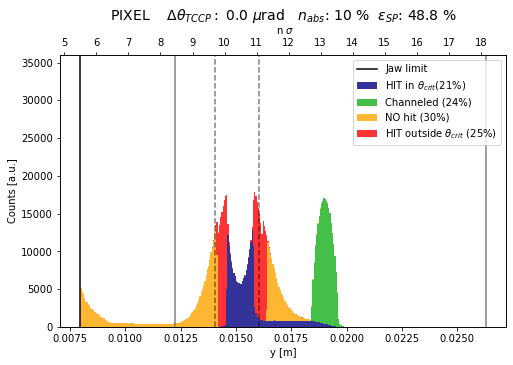

In [21]:
fig_pix, ax_pix = PIX.plot_y(return_fig=True, set_y_dim = 36000)
ax_pix.set_title(PIX_TITLE, fontsize=14)   

Check total:  True
Check ch not xp:  True
Check ch xp:  True
Check single pass channeling efficiency:  0.48779252374112425 0.4880538852411265


Text(0.5, 1.0, 'TFT    $\\Delta\\theta_{{TCCP}}:$ 0.0 $\\mu$rad   $n_{{abs}}$: 10 %  $\\epsilon_{{SP}}$: 48.8 %')

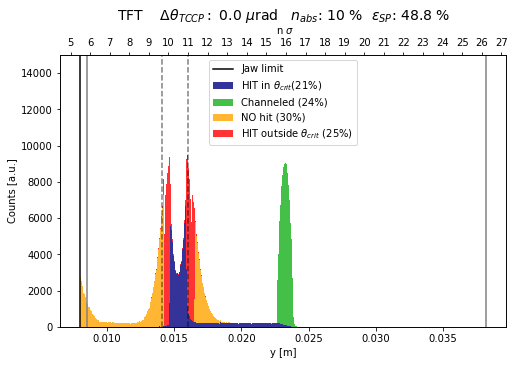

In [22]:
fig_tft, ax_tft = TFT.plot_y(return_fig=True, set_y_dim = 15000)
ax_tft.set_title(TFT_TITLE, fontsize=14)   


Plotting 2D: 


Text(0.5, 1.0, 'TFT    $\\Delta\\theta_{{TCCP}}:$ 0.0 $\\mu$rad   $n_{{abs}}$: 10 %  $\\epsilon_{{SP}}$: 48.8 %')

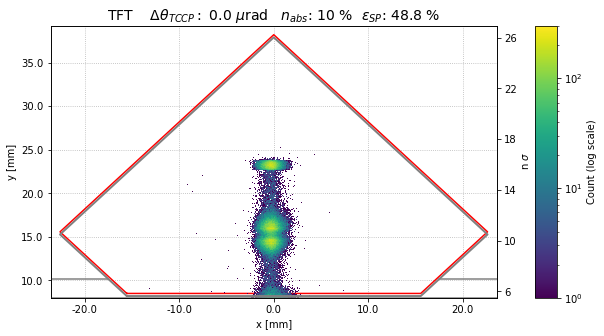

In [23]:
print("\nPlotting 2D: ")
fig_tft2D, ax_tft2D = plt.subplots(figsize=(8, 5))
TFT.plot_xy_distribution(fig_tft2D, ax_tft2D, TFT.data['x'], TFT.data['y'], vmax=300)
ax_tft2D.set_title(TFT_TITLE, fontsize=14)   

Text(0.5, 1.0, 'PIXEL    $\\Delta\\theta_{{TCCP}}:$ 0.0 $\\mu$rad   $n_{{abs}}$: 10 %  $\\epsilon_{{SP}}$: 48.8 %')

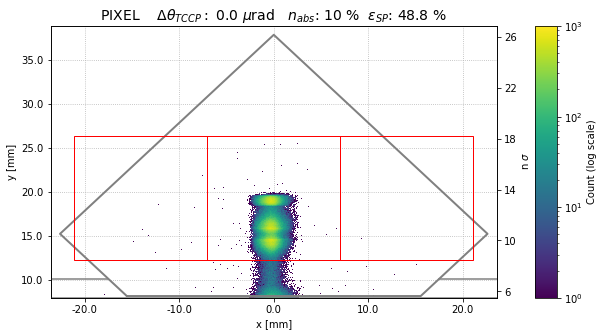

In [24]:
fig_pix2D, ax_pix2D = plt.subplots(figsize=(8, 5))
PIX.plot_xy_distribution(fig_pix2D, ax_pix2D, PIX.data['x'], PIX.data['y'],vmax=1e3)
ax_pix2D.set_title(PIX_TITLE, fontsize=14)   

In [73]:
i_str ="10.1" 
fig_pix.savefig(Path(path_out,f'PIX_1D_{text_suffix}_'+i_str+f'_{ang}.png'), dpi=300, bbox_inches='tight')
fig_tft.savefig(Path(path_out,f'TFT_1D_{text_suffix}_'+i_str+f'_{ang}.png'), dpi=300, bbox_inches='tight')
fig_tft2D.savefig(Path(path_out,f'TFT_2D_{text_suffix}_'+i_str+f'_{ang}.png'), dpi=300, bbox_inches='tight')
fig_pix2D.savefig(Path(path_out,f'PIX_2D_{text_suffix}_'+i_str+f'_{ang}.png'), dpi=300, bbox_inches='tight')

In [74]:
print("\nGetting arrays: ")
# Compute arrays
h_PIX = get_PIX_array(PIX.data, show_plot=False)[0]
h_TFT = get_TFT_array(TFT.data, show_plot=False)[0]



Getting arrays: 
Retrieved bin width (X): [5.5e-05 0.0e+00]
Retrieved bin width (Y): [5.5e-05 0.0e+00]
Retrieved bin width (X): [3.06666667e-05 0.00000000e+00]
Retrieved bin width (Y): [3.06666667e-05 0.00000000e+00]


In [75]:
with pd.HDFStore(hdf_file, mode='a') as store:
    store.put(f"{ang}/h_PIX", pd.DataFrame(h_PIX), format='table')
    store.put(f"{ang}/h_TFT", pd.DataFrame(h_TFT), format='table')


/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '0.0'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


In [76]:

df = pd.read_hdf(file_path_absorbed, key="absorbed")

# Create a one-row DataFrame from ang_dict for angle 0.0
new_row = pd.DataFrame.from_dict({0.0: ang_dict}, orient="index")
new_row.index.name = "delta_angle_TCCP"
new_row.reset_index(inplace=True)

# Append it to the original DataFrame
df_updated = pd.concat([df, new_row], ignore_index=True)

# Optional: drop duplicates if angle 0.0 already exists
df_updated = df_updated.drop_duplicates(subset="delta_angle_TCCP", keep="last")

# Save the updated DataFrame back to HDF5 (overwrite existing key)
df_updated.to_hdf(
    file_path_absorbed,
    key="absorbed",
    format="table",
    mode="a",  # 'a' = append mode for the file
    complevel=9,
    complib="blosc"
)

In [81]:
new_row

,delta_angle_TCCP,TCCS_abs,TCCP_abs,TCLA_abs,PIPE_abs,TCCP_angle,npart,n_impacts
0,0.0,4574,81183,590831,287525,0.000174,1990000,1124069


In [83]:
df_updated

,delta_angle_TCCP,TCCS_abs,TCCP_abs,TCLA_abs,PIPE_abs,TCCP_angle,npart,n_impacts
0,-20.9,3580,115366,585323,14125,0.000142,2000000,1092844
1,-18.7,3581,112488,577124,40047,0.000144,2000000,1095717
2,-16.5,3580,108057,564685,75415,0.000146,2000000,1100153
3,-14.3,3581,102850,548929,116729,0.000148,2000000,1105366
4,-12.1,3582,97151,530222,162110,0.000151,2000000,1111065
5,-9.9,3580,91664,510162,207403,0.000153,2000000,1116540
6,-7.7,3581,87200,490475,246763,0.000155,2000000,1121007
7,-5.5,3581,84598,478287,270004,0.000157,2000000,1123604
8,-3.3,3581,83130,469960,283000,0.000159,2000000,1125070
9,-1.1,3581,82331,466336,288807,0.000162,2000000,1125856


In [6]:
! ls

CreateGif.ipynb					 PIX1D.gif
CRY_rotation2.gif				 PIX_1D_InBEAM.gif
CRY_rotation.gif				 PIX_1D_NEW.gif
DataForML_2.py					 PIX_1D_ROT4.4murad.gif
DataForML_pictures.py				 PIX_2D_InBEAM.gif
DataForML.py					 PIX_2D_NEW.gif
DataForML_TCCSinbeam.py				 PIX_2D_ROT4.4murad.gif
DataLS.py					 PIX.gif
Data_XY.py					 TCCS_inBeam_450GeV_ANGSCAN.h5
DoubleChanneling_450GeV_ANGSCAN.h5		 TFT1D.gif
DoubleChanneling_450GeV_ANGSCAN_ROT-2.2murad.h5  TFT_1D_InBEAM.gif
DoubleChanneling_450GeV_ANGSCAN_ROT2.2murad.h5	 TFT_1D_NEW.gif
DoubleChanneling_450GeV_ANGSCAN_ROT-4.4murad.h5  TFT_1D_ROT4.4murad.gif
DoubleChanneling_450GeV_ANGSCAN_ROT4.4murad.h5	 TFT_2D_InBEAM.gif
DoubleChanneling_450GeV_ANGSCAN_test.h5		 TFT_2D_NEW.gif
Double_Channeling_450_TCCP_-22.0.h5		 TFT_2D_ROT-2.2murad.gif
Figures						 TFT_2D_ROT4.4murad.gif
LS_PIX.gif					 TFT.gif
Outputdata					 Transform_Data.ipynb


In [9]:
from PIL import Image

# Load the image
img = Image.open(f'./Outputdata/PIX_1D_ROT-4.4murad_10.1_0.0.png')

# Get size in pixels
width_px, height_px = img.size

# Get DPI (dots per inch), if available
dpi = img.info.get("dpi", (72, 72))  # Default to 72 DPI if missing
dpi_x, dpi_y = dpi

# Calculate figsize in inches
figsize = (width_px / dpi_x, height_px / dpi_y)
print("Figsize (inches):", figsize)


Figsize (inches): (7.126680920028507, 5.023343380020093)


In [10]:
from PIL import Image

# Load the image
img = Image.open(f'./Outputdata/PIX_1D_ROT-4.4murad_10_1.1.png')

# Get size in pixels
width_px, height_px = img.size

# Get DPI (dots per inch), if available
dpi = img.info.get("dpi", (72, 72))  # Default to 72 DPI if missing
dpi_x, dpi_y = dpi

# Calculate figsize in inches
figsize = (width_px / dpi_x, height_px / dpi_y)
print("Figsize (inches):", figsize)

Figsize (inches): (7.126680920028507, 5.096676860020387)


In [25]:
fig_size = fig_pix2D.get_size_inches()
print("Figsize (inches):", fig_size)

Figsize (inches): [8. 5.]


In [27]:

from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

canvas = FigureCanvas(fig_pix2D)

# Draw the renderer
canvas.draw()

# Get bounding box in inches
bbox_inches = fig_pix2D.get_tightbbox(canvas.get_renderer())
print("Tight bounding box (inches):", bbox_inches.width, "x", bbox_inches.height)

# Convert to pixels using DPI
dpi = fig_pix2D.dpi
width_px = int(bbox_inches.width * dpi)
height_px = int(bbox_inches.height * dpi)
print(f"Estimated saved image size with bbox_inches='tight': {width_px} x {height_px} pixels")



Tight bounding box (inches): 8.18895290798611 x 4.469444444444444
Estimated saved image size with bbox_inches='tight': 589 x 321 pixels
